In [1]:
import pandas as pd
import numpy as np

import os
import pickle

import sklearn
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder

import xgboost as xgb

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Bidirectional, TimeDistributed, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
from keras.utils import np_utils
from keras.utils import plot_model

import shap
import lime

from PIL import Image

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
base_folder = "/home/sunny/Data for ML Project"
project_folder = "Batch 1 Regular Ranking"
batch = "/home/sunny/Batch1"

if not os.path.exists(batch):
    os.mkdir(batch)
    
total_data, labels = [], []

for file in sorted(os.listdir(os.path.join(base_folder, project_folder))):
    df = pd.read_csv(os.path.join(base_folder, project_folder, file))
    total_data.append(df.fillna(value=0).drop(columns=["ticker", "returns"]).values.tolist())
    labels.append(df["returns"].values.tolist())
    
total_data = np.array(total_data)
labels = np.array(labels)

print(total_data.shape, labels.shape)

(52, 505, 131) (52, 505)


In [3]:
dfs = []
for file in sorted(os.listdir(os.path.join(base_folder, project_folder))):
    df = pd.read_csv(os.path.join(base_folder, project_folder, file))
    dfs.append(df.fillna(value=0))
    
combined_df = pd.concat(dfs)
combined_df.head()

ticker  SQN_Q1_CI  SQN_Q2_CI  SQN_Q3_CI  SQN_Q4_CI  SQN_Q1  SQN_Q2  SQN_Q3  \
0      A        3.0      184.0      422.0      358.0     3.0   186.0   422.0   
1    AAL      110.0      374.0      340.0       38.0   233.0   344.0   174.0   
2    AAP      408.0        7.0       93.0      157.0   437.0     6.0    58.0   
3   AAPL        4.0       50.0      216.0      118.0     1.0    53.0   216.0   
4   ABBV        0.0        0.0        0.0        0.0     0.0     0.0     0.0   

   SQN_Q4  IV_calls_0  ...  zomma_puts_180  speed_puts_180  color_puts_180  \
0   329.0       146.0  ...           311.0           348.0           363.0   
1    64.0         0.0  ...             0.0             0.0             0.0   
2   106.0       207.0  ...           142.0           188.0           134.0   
3    95.0       182.0  ...            73.0           103.0            69.0   
4     0.0         0.0  ...             0.0             0.0             0.0   

   dual_delta_puts_180  dual_gamma_puts_180   IV_0  IV_30  IV_120  IV_180  \
0                243.0                137.0  155.0  209.0   161.0   141.0   
1                  0.0                  0.0    0.0    0.0     0.0     0.0   
2                345.0                315.0  230.0   51.0   294.0   293.0   
3                323.0                414.0  196.0  109.0   122.0   182.0   
4                  0.0                  0.0    0.0    0.0     0.0     0.0   

   returns  
0      1.0  
1      1.0  
2     -1.0  
3     -1.0  
4     -1.0  

[5 rows x 133 columns]

## Plotting Correlation Matrix

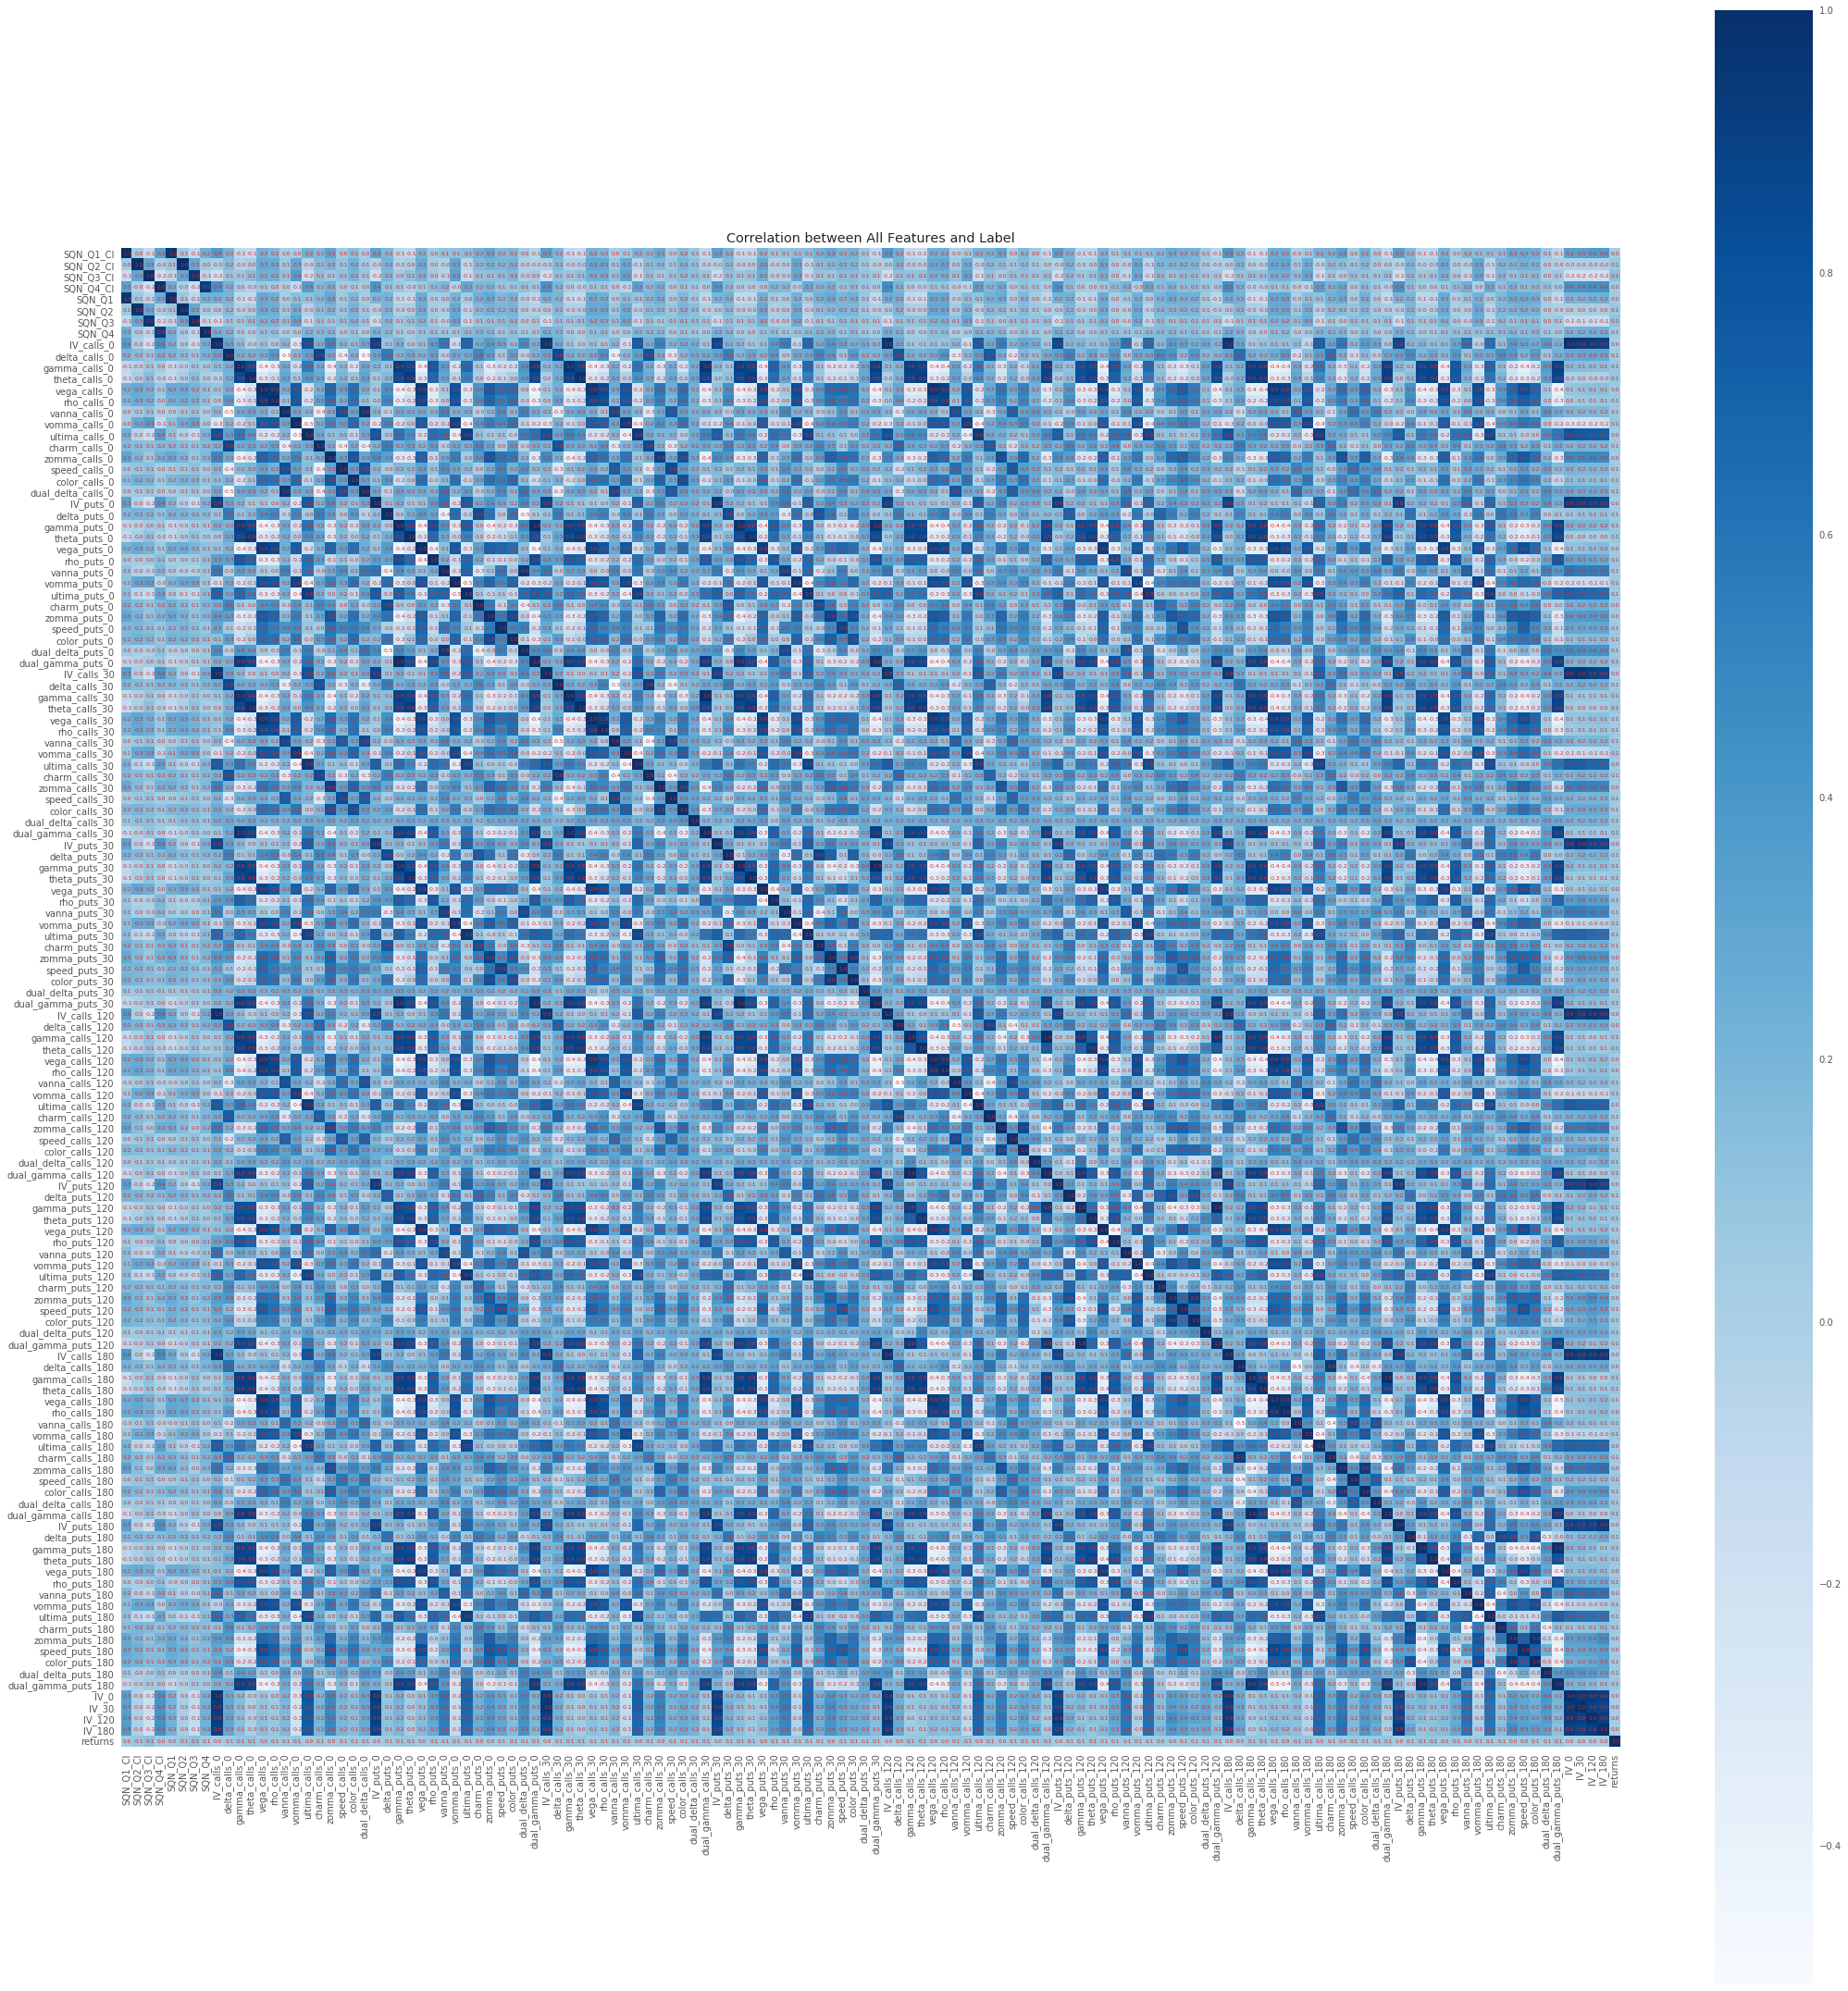

In [4]:
def plot_correlation_matrix(df, titl):
    plt.imshow(df.values, cmap=plt.cm.Blues)
    plt.xticks(range(df.shape[0]), df.columns, rotation='vertical')
    plt.yticks(range(df.shape[0]), df.columns)
    plt.title(titl)
    plt.colorbar()
    plt.grid(None)
    for i in range(0,df.shape[0]):
        for j in range(0, df.shape[0]):
            if df.values[i, j] < 0:
                plt.text(i-0.4, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=6);
            else:
                plt.text(i-0.3, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=6);
                
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(30,30))
    plot_correlation_matrix(combined_df.drop(columns=["ticker"]).corr(), 'Correlation between All Features and Label')
                
    plt.tight_layout()
    
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
    
    plt.savefig(os.path.join(batch,"correlation.png"), dpi=200)


## P-values and F-values For Classification

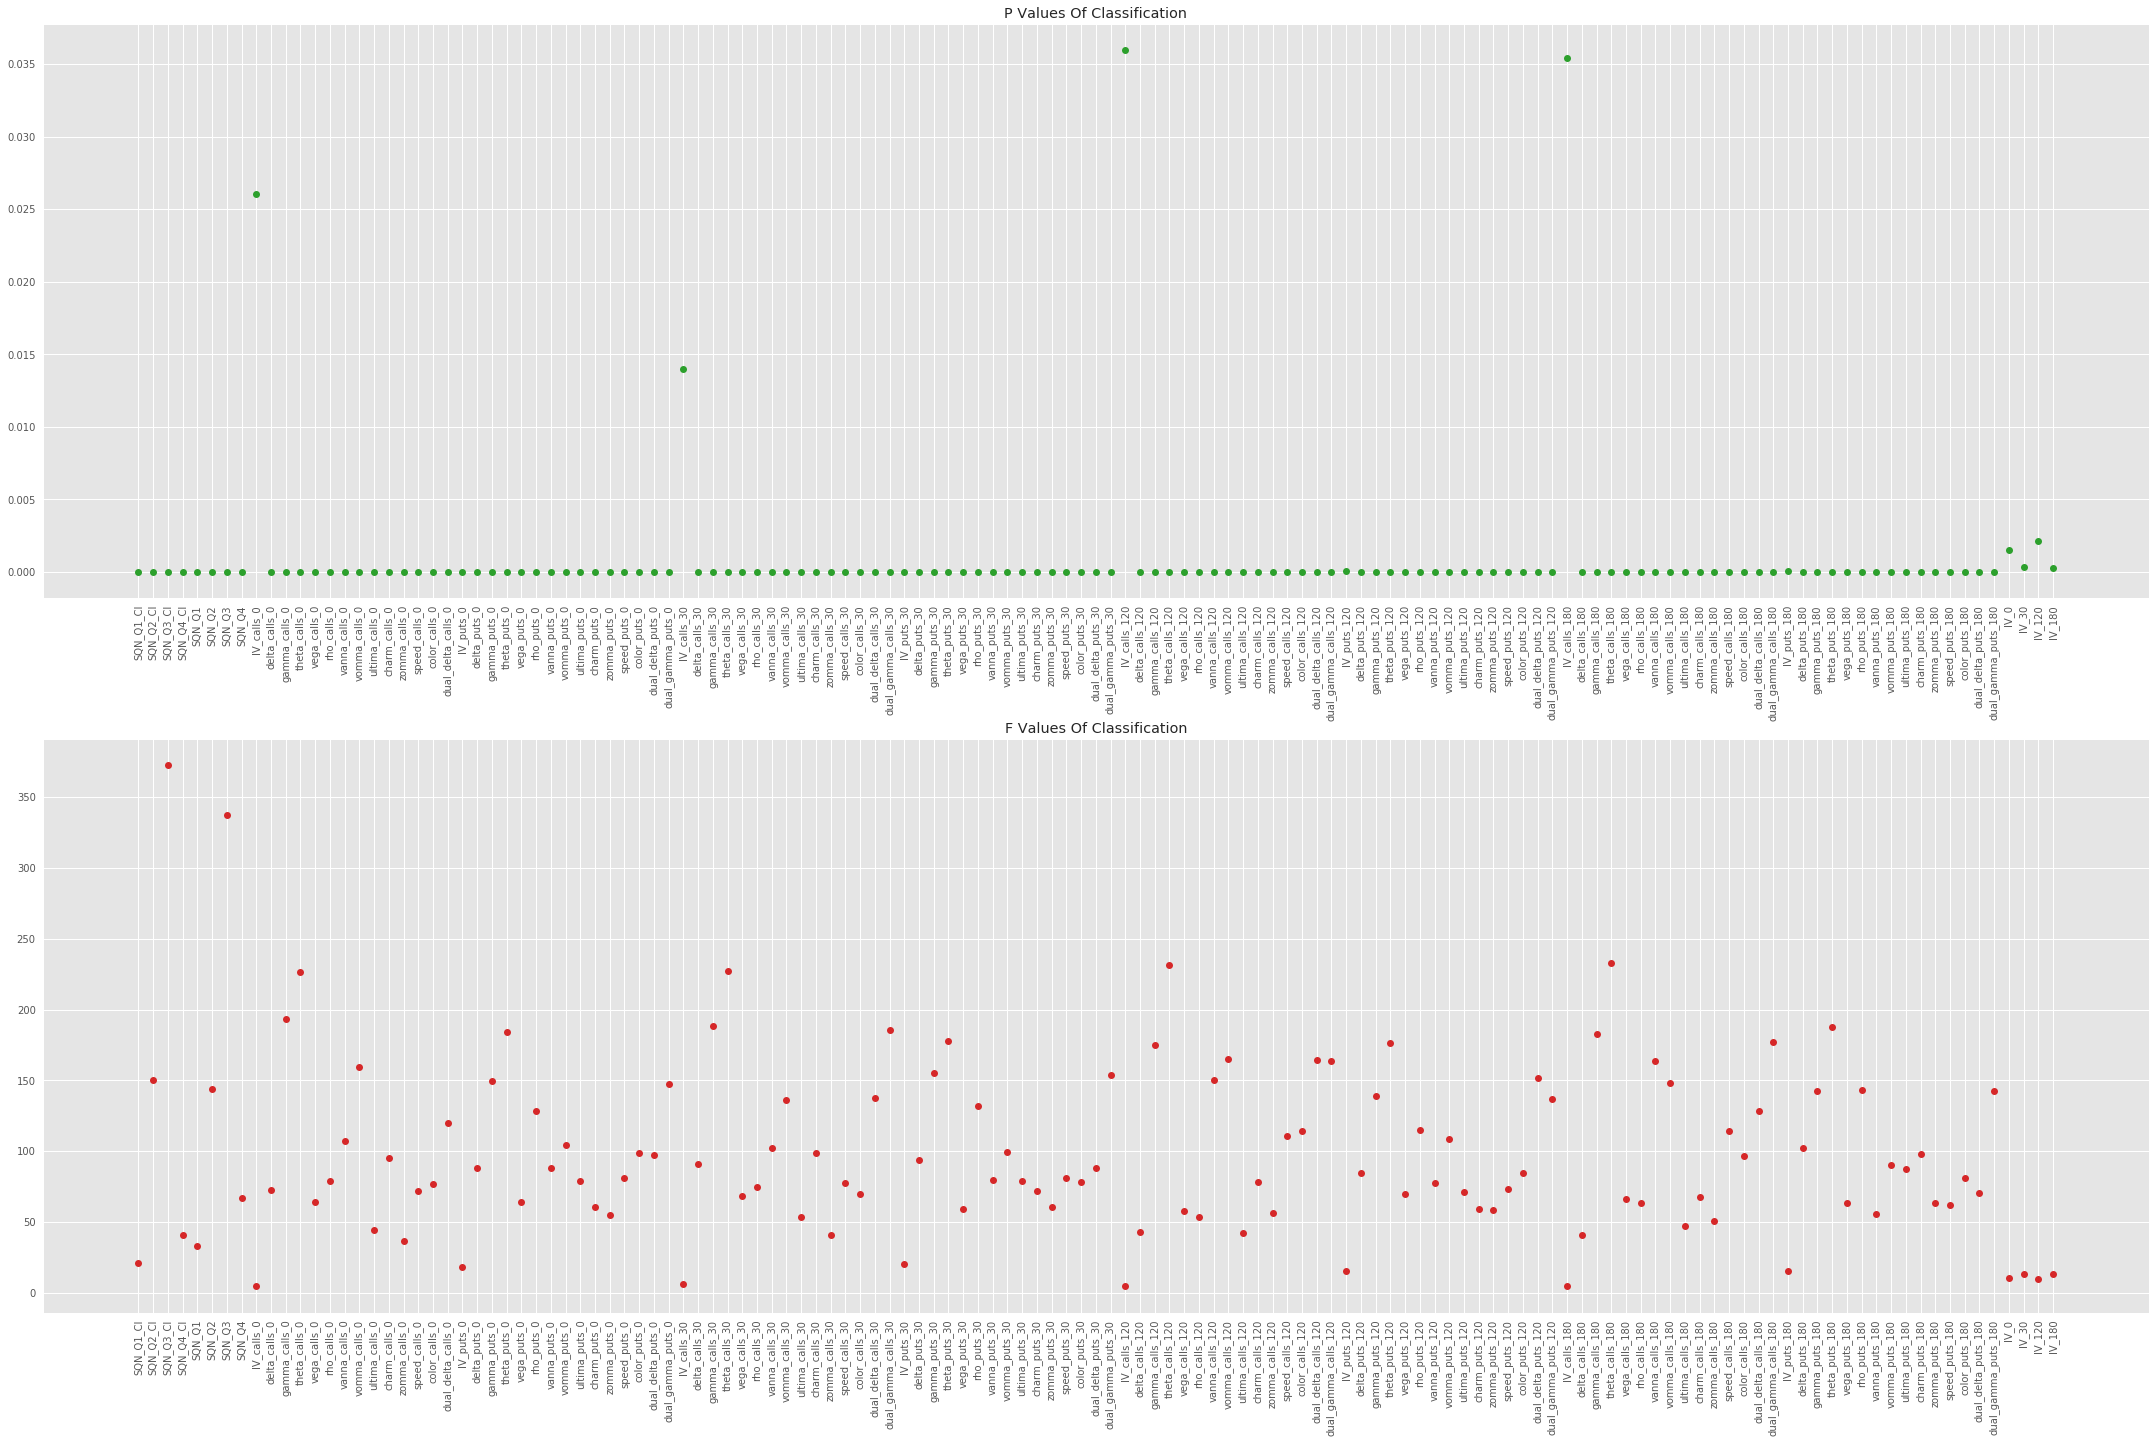

In [5]:
X = combined_df.drop(columns=["ticker","returns"])
X = MinMaxScaler().fit_transform(X)
Y = combined_df['returns'].values
Y = np.array([1 if y==1 else 0 for y in Y])

cols = combined_df.drop(columns=["ticker", "returns"]).columns

F_classif, p_value_classif = f_classif(X, Y)

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(30,20))
    plt.subplot(211)
    plt.plot(p_value_classif, 'o', c = 'tab:green')
    plt.xticks(range(X.shape[1]), cols, rotation='vertical')
    plt.title('P Values Of Classification')
    plt.subplot(212)
    plt.plot(F_classif, 'o', c = 'tab:red')
    plt.xticks(range(X.shape[1]), cols, rotation='vertical')
    plt.title('F Values Of Classification');
    
    plt.tight_layout()
    
    plt.savefig(os.path.join(batch,"f_p_values.png"), dpi=200)

In [6]:
def plot_confusion_matrix(actuals, preds):
    conf_mat = confusion_matrix(actuals, preds)
    with plt.style.context(('seaborn', 'ggplot')):
        fig = plt.figure(figsize=(10,10))
        plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
        plt.xticks([0, 1], [-1, 1])
        plt.yticks([0, 1], [-1, 1])
        plt.grid(None)
        plt.ylabel('Actual')
        plt.xlabel('Prediction')
        plt.colorbar();
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                plt.text(j, i, str(conf_mat[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
                
def plot_loss_and_accuracy(hist, prob_type='classification'):
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(hist.history['loss'], label='Train Loss')
        plt.plot(hist.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')
        
        if prob_type=='classification':
            plt.subplot(122)
            plt.plot(hist.history['accuracy'], label='Train Accuracy')
            plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
        elif prob_type=='regression':
            plt.subplot(122)
            plt.plot(hist.history['mse'], label='Train MSE')
            plt.plot(hist.history['val_mse'], label='Val MSE')
            plt.xlabel('Epochs')
            plt.ylabel('MSE')
            plt.legend(loc='best')
            
            
def print_plot_metrics(model_name, Y_test, predictions):
    print('Classification Report : \n',classification_report(Y_test, predictions))
    print('Confusion Matrix : \n', confusion_matrix(Y_test, predictions))
    plot_confusion_matrix(Y_test, predictions)
    
    
def print_weights_per_layer(model):
    weights = model.get_weights()
    layers = [layer for layer in model.layers if layer.__class__.__name__ != 'Dropout']

    i = 0
    for layer in layers:
        if layer.__class__.__name__ =='Dense':
            print('Layer : %s : Weights : %s'%(layer.__class__.__name__, weights[i].shape))
            print('Layer : %s : Bias : %s'%(layer.__class__.__name__, weights[i+1].shape))
            i = i+2
        else:
            print('Layer : %s : Weights : %s'%(layer.__class__.__name__, weights[i].shape))
            i = i+1

## 1. Dense Net V1

### Data Preparation

In [7]:
total_data, labels = [], []

for file in sorted(os.listdir(os.path.join(base_folder, project_folder))):
    df = pd.read_csv(os.path.join(base_folder, project_folder, file))
    labels.append([1 if ret==1 else 0 for ret in df["returns"].values.tolist()])
    df = pd.get_dummies(df.fillna(value=0).drop(columns=["returns"]), columns=["ticker"])
    total_data.append(df.values.tolist())
    
    
total_data = np.array(total_data)
labels = np.array(labels)

print(total_data.shape, labels.shape)

(52, 505, 636) (52, 505)


In [8]:
X, Y = total_data[:-1], labels[1:]

print(X.shape, Y.shape)

X_train, X_test = X[:49], X[49:]
Y_train, Y_test = Y[:49], Y[49:]

X_train, X_val = X_train[:47], X_train[47:]
Y_train, Y_val = Y_train[:47], Y_train[47:]

X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

(51, 505, 636) (51, 505)


((47, 505, 636), (2, 505, 636), (2, 505, 636), (47, 505), (2, 505), (2, 505))

In [9]:
X = X.reshape((-1, total_data.shape[-1]))
Y = Y.flatten()

print(X.shape, Y.shape)

X_train = X_train.reshape((-1, X_train.shape[-1]))
X_val = X_val.reshape((-1, X_val.shape[-1]))
X_test = X_test.reshape((-1, X_test.shape[-1]))

Y_train = Y_train.flatten()
Y_val = Y_val.flatten()
Y_test = Y_test.flatten()

X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

(25755, 636) (25755,)


((23735, 636), (1010, 636), (1010, 636), (23735,), (1010,), (1010,))

### Model Creation

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               81536     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

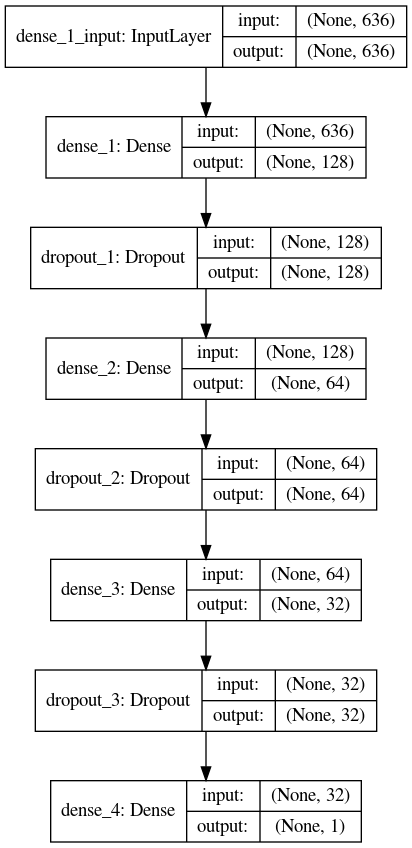

In [10]:
dense_model1 = Sequential([ 
                     Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
                     #BatchNormalization(),      
                     Dropout(0.2),
                     Dense(64,  activation='relu'),
                     #BatchNormalization(),  
                     Dropout(0.2),
                     Dense(32,  activation='relu'),
                     #BatchNormalization(),
                     Dropout(0.2),
                     Dense(1,   activation='sigmoid')])

print(dense_model1.summary())
plot_model(dense_model1, to_file=os.path.join(batch, 'dense1.png'), show_shapes=True)
Image.open(os.path.join(batch, 'dense1.png'))

### Model Compilation

In [11]:
dense_model1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

### Model Training

In [12]:
history = dense_model1.fit(X_train, Y_train, batch_size=505, epochs=5, validation_data=(X_val, Y_val), verbose=1,shuffle=False, use_multiprocessing=True);

Train on 23735 samples, validate on 1010 samples
Epoch 1/5
23735/23735 [==============================] - 4s 178us/step - loss: 4.9280 - accuracy: 0.5158 - val_loss: 0.7868 - val_accuracy: 0.4851
Epoch 2/5
23735/23735 [==============================] - 1s 38us/step - loss: 1.0524 - accuracy: 0.5129 - val_loss: 0.7162 - val_accuracy: 0.5089
Epoch 3/5
23735/23735 [==============================] - 1s 35us/step - loss: 0.8164 - accuracy: 0.5248 - val_loss: 0.7021 - val_accuracy: 0.4891
Epoch 4/5
23735/23735 [==============================] - 1s 35us/step - loss: 0.7604 - accuracy: 0.5216 - val_loss: 0.6998 - val_accuracy: 0.4653
Epoch 5/5
23735/23735 [==============================] - 1s 34us/step - loss: 0.7228 - accuracy: 0.5195 - val_loss: 0.6890 - val_accuracy: 0.5178


### Visualizing Training Results

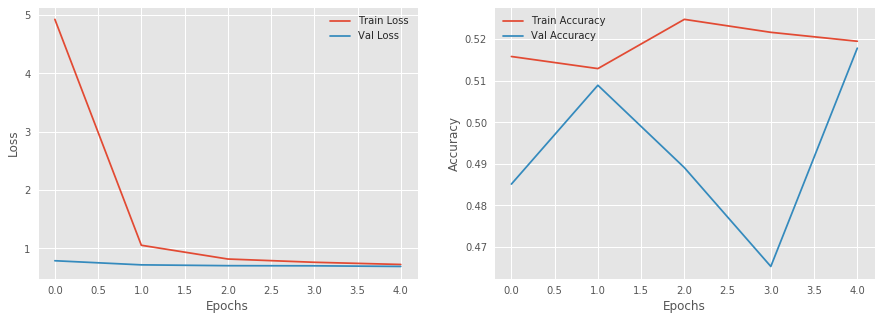

In [13]:
plot_loss_and_accuracy(history)

### Checking Accuracy On Test Data

In [14]:
predictions = dense_model1.predict_classes(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions.flatten()))

Accuracy : 0.542


In [15]:
#predictions_full = dense_model1.predict_classes(X)
#print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))

In [16]:
probs = dense_model1.predict_proba(X).flatten()
probs[:10]

array([0.4592098 , 0.4627126 , 0.48788416, 0.48226398, 0.25843585,
       0.4994225 , 0.5205056 , 0.4549916 , 0.50828326, 0.5291182 ],
      dtype=float32)

### Printing & Visualizing Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.49      0.62      0.55       451
           1       0.61      0.48      0.54       559

    accuracy                           0.54      1010
   macro avg       0.55      0.55      0.54      1010
weighted avg       0.56      0.54      0.54      1010

Confusion Matrix : 
 [[279 172]
 [291 268]]


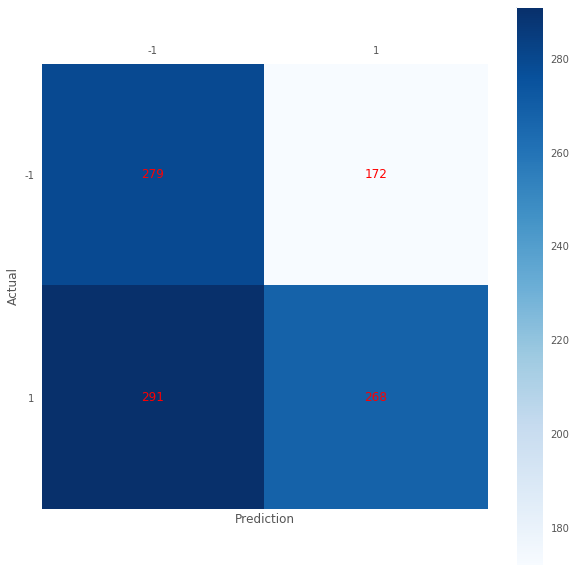

In [17]:
print_plot_metrics('DenseNetv1', Y_test, predictions.flatten())

In [18]:
print_weights_per_layer(dense_model1)

Layer : Dense : Weights : (636, 128)
Layer : Dense : Bias : (128,)
Layer : Dense : Weights : (128, 64)
Layer : Dense : Bias : (64,)
Layer : Dense : Weights : (64, 32)
Layer : Dense : Bias : (32,)
Layer : Dense : Weights : (32, 1)
Layer : Dense : Bias : (1,)


### Visualizing Weights FOr Features

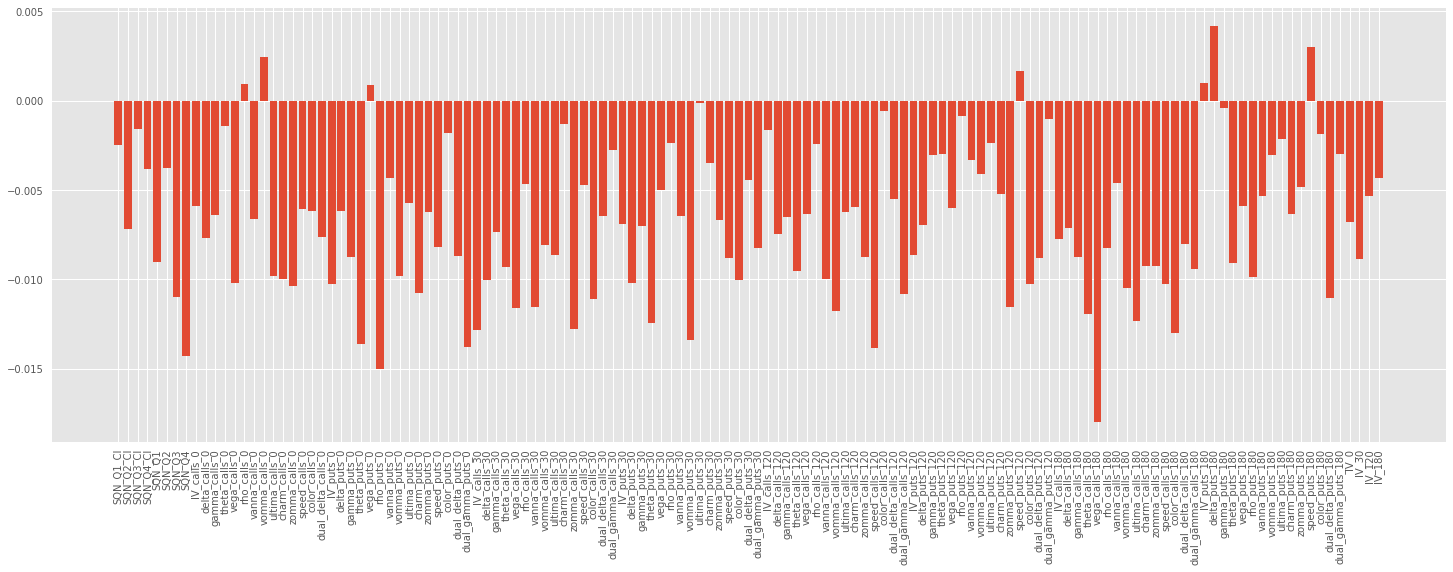

In [19]:
dense_weights = dense_model1.get_weights()
important_weights = dense_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights[:-505], width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_dense_v1.png"), dpi=200)

### Saving Model & Loading From Saved File

In [20]:
dense_model1.save(os.path.join(batch,"dense_classifier_v1.h5"))

In [21]:
dense_model1 = load_model(os.path.join(batch,"dense_classifier_v1.h5"))

dense_model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               81536     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

### Future Values Prediction

In [22]:
def future_predictions(file_name, model):
    df = pd.read_csv(file_name)
    df = pd.get_dummies(df.drop(columns=["returns"]), columns=["ticker"])
    df = df.fillna(value=0)

    data = df.values
    #data = data.reshape((1, data.shape[0], data.shape[1]))

    prediction_probs = model.predict(data).flatten()
    prediction_labels = np.where(prediction_probs > 0.5, 1, -1)
    
    return prediction_probs, prediction_labels

In [23]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

probs, labels = future_predictions(last_file, dense_model1)

probs[:5], labels[:5]

(array([0.48666587, 0.46332437, 0.4844781 , 0.48882836, 0.5065708 ],
       dtype=float32), array([-1, -1, -1, -1,  1]))

### Adding Probabilities to Combined Data Frame

In [24]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, dense_model1)
    tot_probs.extend(probs)
    tot_labels.extend(labels)

combined_df_final = combined_df.copy()
combined_df_final["DenseV1_Probs"] = tot_probs
combined_df_final["DenseV1_Preds"] = tot_labels

## 2. Dense Model V2

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               63700     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 300)               60300     
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

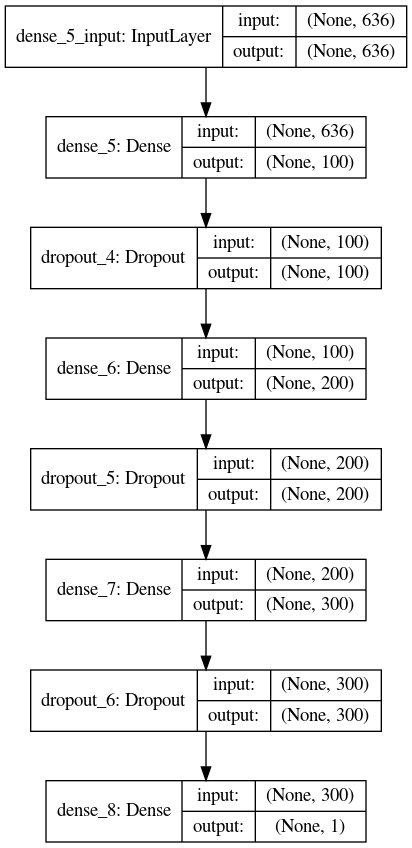

In [25]:
dense_model2 = Sequential([ 
                     Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
                     Dropout(0.1),
                     Dense(200,  activation='relu'),
                     Dropout(0.1),
                     Dense(300,  activation='relu'),
                     Dropout(0.1),
                     Dense(1,   activation='sigmoid')])

print(dense_model2.summary())
plot_model(dense_model2, to_file=os.path.join(batch, 'dense2.png'), show_shapes=True)
Image.open(os.path.join(batch, 'dense2.png'))

In [26]:
dense_model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [27]:
history = dense_model2.fit(X_train, Y_train, batch_size=505, epochs=5, validation_data=(X_val, Y_val), verbose=1,shuffle=False, use_multiprocessing=True);

Train on 23735 samples, validate on 1010 samples
Epoch 1/5
23735/23735 [==============================] - 1s 36us/step - loss: 6.6654 - accuracy: 0.5122 - val_loss: 0.9018 - val_accuracy: 0.4990
Epoch 2/5
23735/23735 [==============================] - 1s 29us/step - loss: 0.8715 - accuracy: 0.5284 - val_loss: 0.7117 - val_accuracy: 0.5208
Epoch 3/5
23735/23735 [==============================] - 1s 23us/step - loss: 0.7371 - accuracy: 0.5334 - val_loss: 0.6994 - val_accuracy: 0.5248
Epoch 4/5
23735/23735 [==============================] - 1s 23us/step - loss: 0.7165 - accuracy: 0.5348 - val_loss: 0.6928 - val_accuracy: 0.5297
Epoch 5/5
23735/23735 [==============================] - 1s 31us/step - loss: 0.7010 - accuracy: 0.5345 - val_loss: 0.6910 - val_accuracy: 0.5287


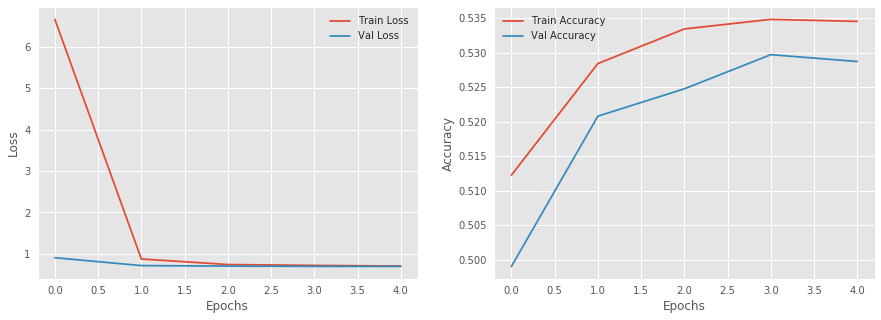

In [28]:
plot_loss_and_accuracy(history)

In [29]:
predictions = dense_model2.predict_classes(X_test).flatten()
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.471


In [30]:
predictions_full = dense_model2.predict_classes(X).flatten()
print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))

Accuracy : 0.538


In [31]:
probs = dense_model2.predict_proba(X).flatten()
probs[:10]

array([0.4736131 , 0.6978807 , 0.4491748 , 0.4736131 , 0.18440354,
       0.4736131 , 0.4736131 , 0.4736131 , 0.4736131 , 0.4736131 ],
      dtype=float32)

Classification Report : 
               precision    recall  f1-score   support

           0       0.45      0.91      0.61       451
           1       0.62      0.12      0.20       559

    accuracy                           0.47      1010
   macro avg       0.54      0.51      0.40      1010
weighted avg       0.54      0.47      0.38      1010

Confusion Matrix : 
 [[410  41]
 [493  66]]


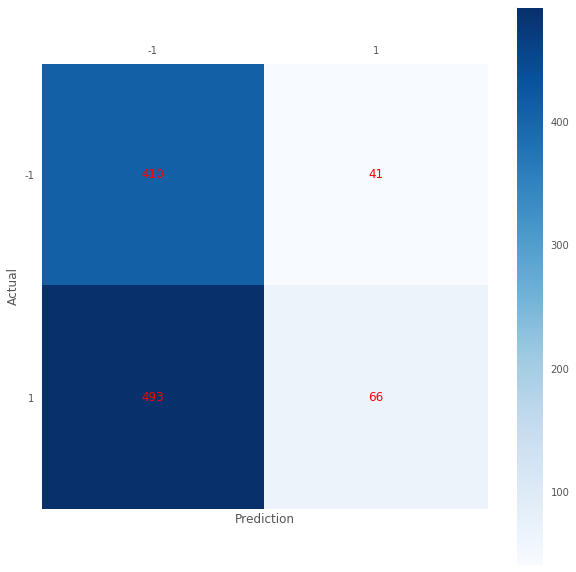

In [32]:
print_plot_metrics('DenseNetv2', Y_test, predictions)

In [33]:
print_weights_per_layer(dense_model2)

Layer : Dense : Weights : (636, 100)
Layer : Dense : Bias : (100,)
Layer : Dense : Weights : (100, 200)
Layer : Dense : Bias : (200,)
Layer : Dense : Weights : (200, 300)
Layer : Dense : Bias : (300,)
Layer : Dense : Weights : (300, 1)
Layer : Dense : Bias : (1,)


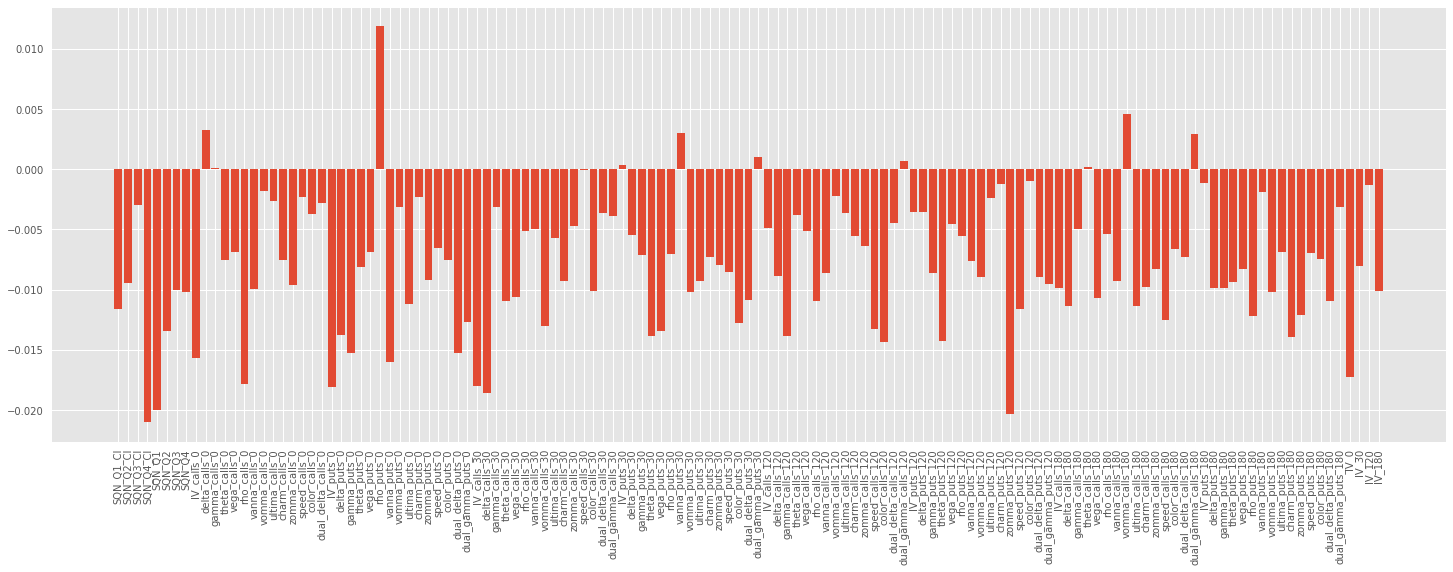

In [34]:
dense_weights = dense_model2.get_weights()
important_weights = dense_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights[:-505], width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_dense_v2.png"), dpi=200)

In [35]:
dense_model2.save(os.path.join(batch,"dense_classifier_v2.h5"))

In [36]:
dense_model2 = load_model(os.path.join(batch,"dense_classifier_v2.h5"))

dense_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               63700     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 300)               60300     
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [37]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

probs, labels = future_predictions(last_file, dense_model2)

probs[:5], labels[:5]

(array([0.4736131 , 0.512156  , 0.4736131 , 0.47936007, 0.4736131 ],
       dtype=float32), array([-1,  1, -1, -1, -1]))

In [38]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, dense_model1)
    tot_probs.extend(probs)
    tot_labels.extend(labels)
    
combined_df_final["DenseV2_Probs"] = tot_probs
combined_df_final["DenseV2_Preds"] = tot_labels

## 3. XGB Classifier

In [39]:
xgb_classif = xgb.XGBRFClassifier(n_estimators=500, max_depth=15, objective='binary:logistic', verbosity=1)

In [40]:
xgb_classif.fit(X_train, Y_train)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=10, min_child_weight=1, missing=None,
                n_estimators=500, n_jobs=1, nthread=None,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                subsample=0.8, verbosity=1)

In [41]:
predictions = xgb_classif.predict(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.511


Classification Report : 
               precision    recall  f1-score   support

           0       0.46      0.62      0.53       451
           1       0.58      0.42      0.49       559

    accuracy                           0.51      1010
   macro avg       0.52      0.52      0.51      1010
weighted avg       0.53      0.51      0.51      1010

Confusion Matrix : 
 [[279 172]
 [322 237]]


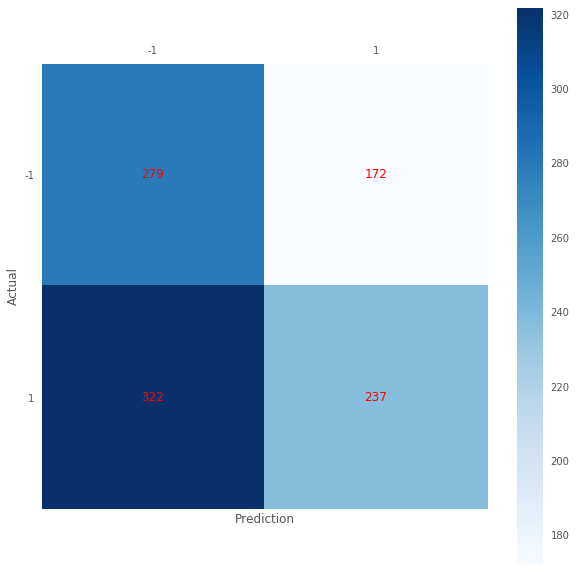

In [42]:
print_plot_metrics('XGB', Y_test, predictions)

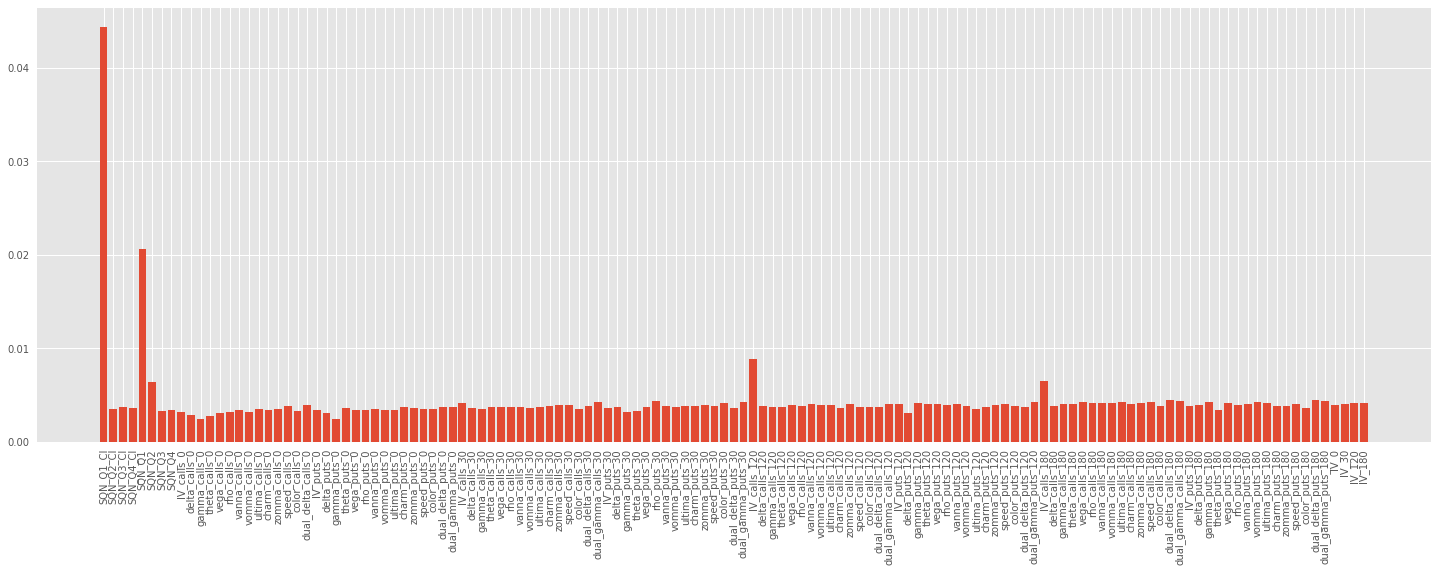

In [43]:
with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=xgb_classif.feature_importances_[:-505], width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_xgb.png"), dpi=200)

In [44]:
feature_cols = combined_df.drop(columns=["ticker", "returns"]).columns.tolist()
feature_cols = feature_cols + combined_df[:505].ticker.values.tolist()

print(len(feature_cols))

636


In [45]:
j=3  ## Data Sample to Analyze

In [1]:
shap.initjs()

explainerXGB = shap.TreeExplainer(xgb_classif, feature_perturbation="tree_path_dependent")

NameError: name 'shap' is not defined

In [47]:
%%time

#shap_values_XGB_train = explainerXGB.shap_values(X_train, Y_train)
shap_values_XGB_test = explainerXGB.shap_values(X_test, Y_test)

CPU times: user 55.9 s, sys: 92.2 ms, total: 56 s
Wall time: 56.1 s


In [48]:
#shap.force_plot(base_value=explainerXGB.expected_value, 
#                shap_values=shap_values_XGB_train[j],
#                features = X_train[j],
#                feature_names=feature_cols)

In [49]:
shap.force_plot(base_value=explainerXGB.expected_value, 
                shap_values=shap_values_XGB_test[j],
                features = X_test[j],
                feature_names=feature_cols)

In [50]:
#shap.summary_plot(shap_values_XGB_train, X_train, plot_type="bar", feature_names=feature_cols, max_display=131)

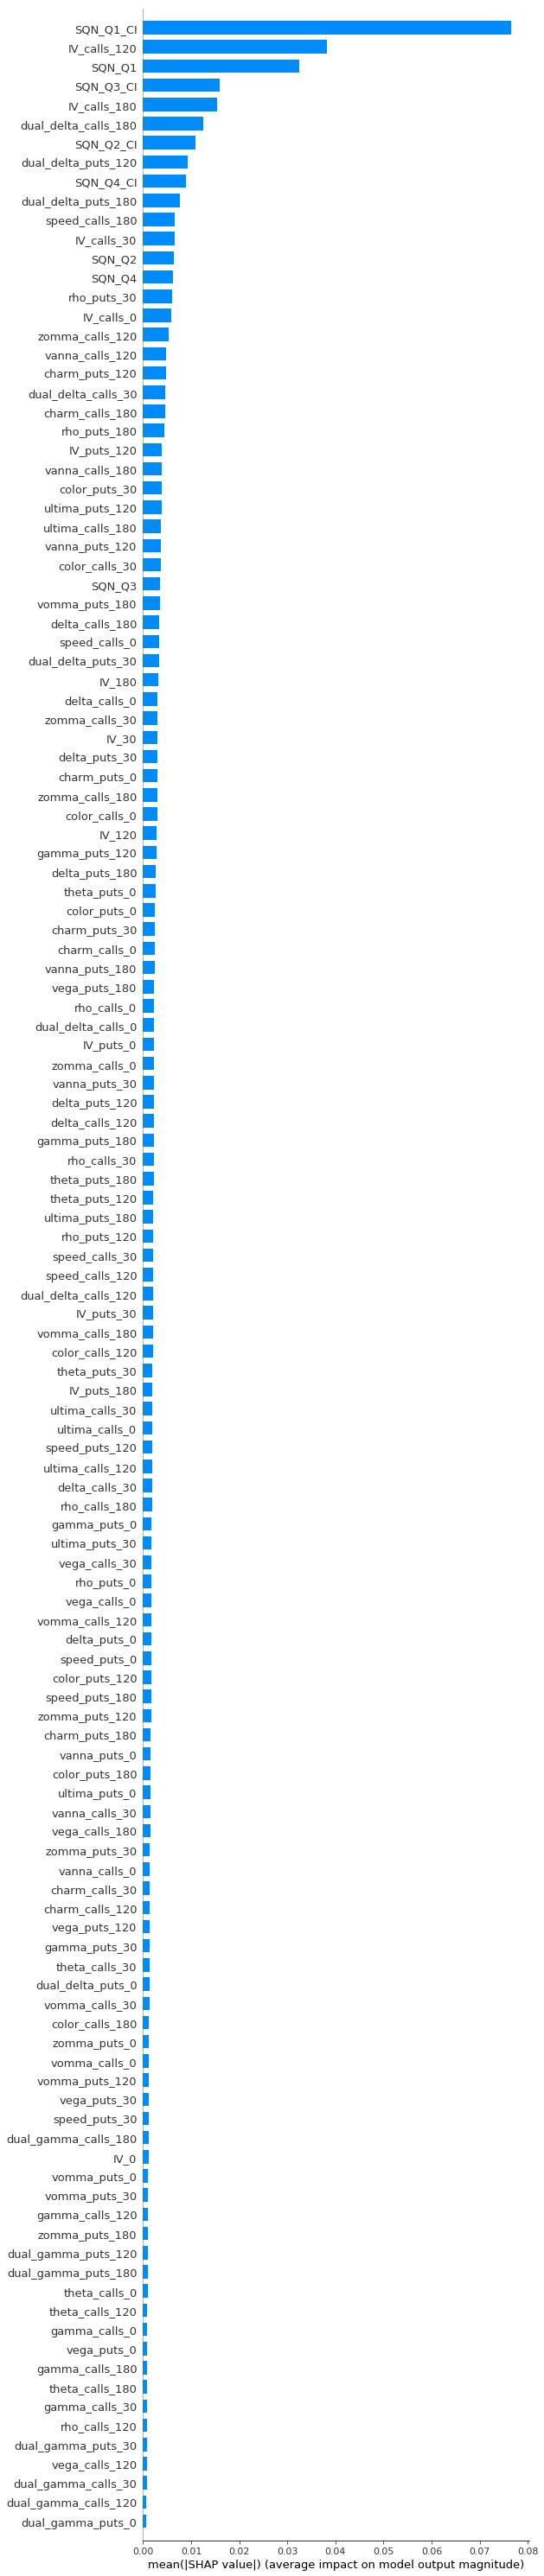

In [51]:
shap.summary_plot(shap_values_XGB_test, X_test, plot_type="bar", feature_names=feature_cols, max_display=131)

In [52]:
#shap.summary_plot(shap_values_XGB_train, X_train, feature_names=feature_cols, max_display=131)

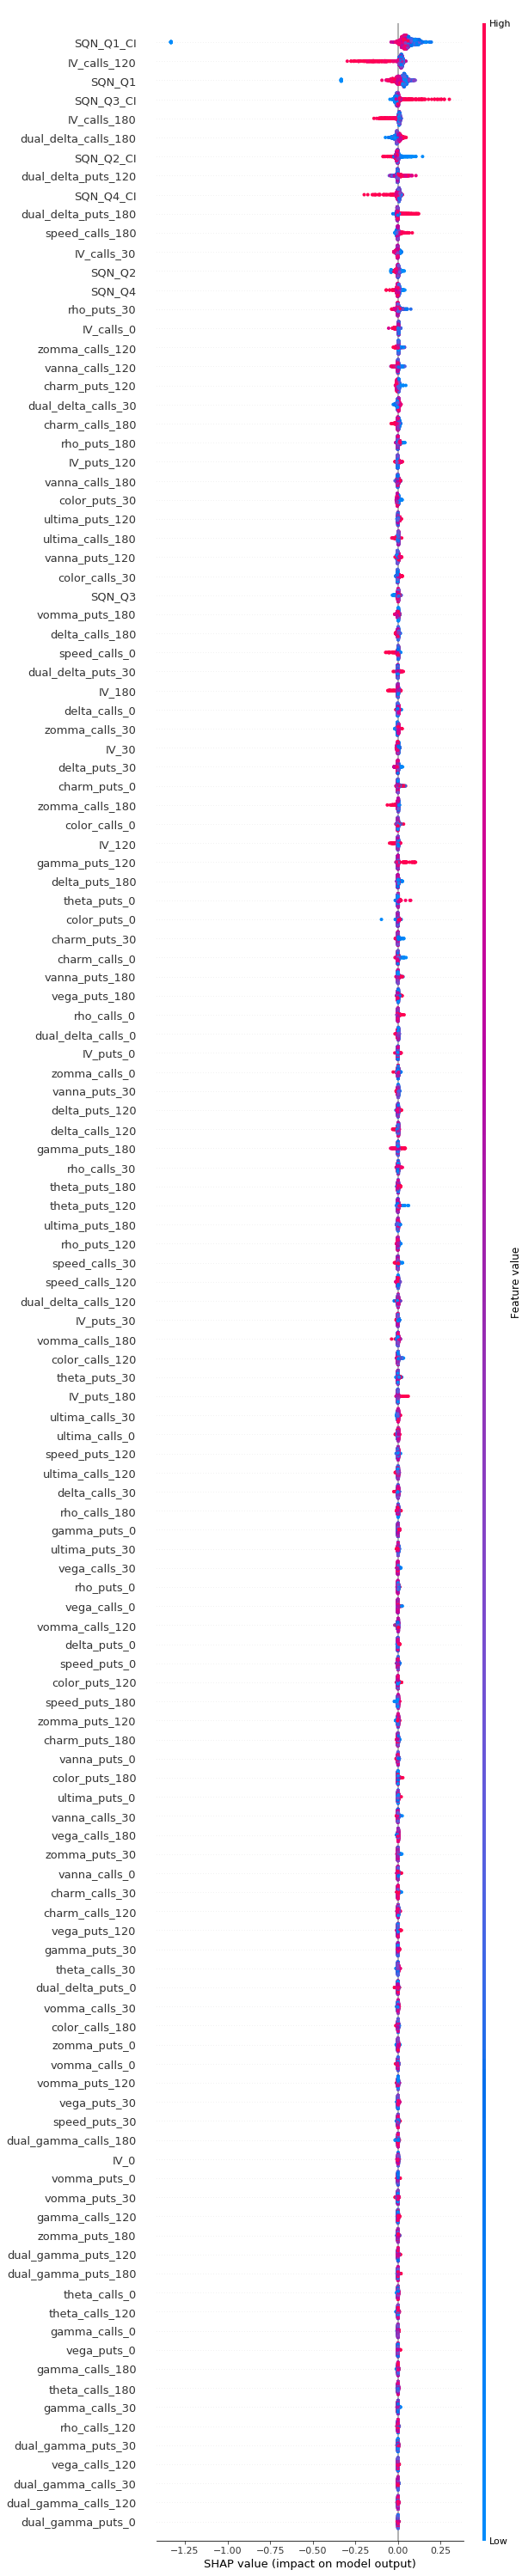

In [53]:
shap.summary_plot(shap_values_XGB_test, X_test, feature_names=feature_cols, max_display=131)

In [54]:
#shp_plt = shap.dependence_plot(feature_cols.index("SQN_Q1_CI"), shap_values_XGB_train, X_train)

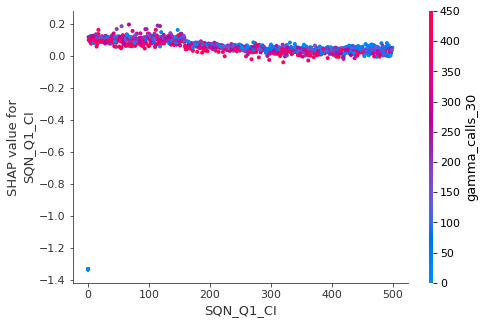

In [55]:
shp_plt = shap.dependence_plot(feature_cols.index("SQN_Q1_CI"), shap_values_XGB_test, X_test, feature_names=feature_cols)

In [56]:
j=3

idx = X_test[j][-505:].tolist().index(1)
print("Prediction Ticker : ", combined_df[:505].ticker[idx])
print("Prediction Values",Y_test[j])


explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_cols,
                                                   class_names=['Negative Return [-1]', "Positive Return [1]"],
                                                   training_labels=Y_train,
                                                   categorical_features=range(131,636),
                                                   categorical_names=dict([(i, [0,1]) for i in range(131,636)]),
                                                   verbose=True,)

expXGB = explainer.explain_instance(X_test[j], 
                                    xgb_classif.predict_proba, 
                                    labels=[0,1],
                                    num_features=X_train.shape[0])

expXGB.show_in_notebook(show_table=True)

Prediction Ticker :  AAPL
Prediction Values 1
Intercept 0.5223205684093136
Prediction_local [0.49881258]
Right: 0.47513312
Intercept 0.477679512894247
Prediction_local [0.50118741]
Right: 0.5248669


In [57]:
probs = xgb_classif.predict_proba(X_test)
probs = probs[:, 1]

probs[:5]

array([0.48453012, 0.49264127, 0.4844568 , 0.5248669 , 0.45207033],
      dtype=float32)

In [58]:
pickle.dump(xgb_classif, open(os.path.join(batch,"xgb_classif.pkl"), "wb"))

xgb_classif_loaded = pickle.load(open(os.path.join(batch,"xgb_classif.pkl"), "rb"))

xgb_classif_loaded

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=10, min_child_weight=1, missing=nan, n_estimators=500,
                n_jobs=1, nthread=None, objective='binary:logistic',
                random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                seed=None, silent=None, subsample=0.8, verbosity=1)

In [59]:
probs = xgb_classif_loaded.predict_proba(X_test)
probs = probs[:, 1]

probs[:5]

array([0.48453012, 0.49264127, 0.4844568 , 0.5248669 , 0.45207033],
      dtype=float32)

In [60]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

def future_predictions(file_name, model):
    df = pd.read_csv(file_name)
    df = pd.get_dummies(df.drop(columns=["returns"]), columns=["ticker"])
    df = df.fillna(value=0)

    data = df.values

    prediction_probs = model.predict_proba(data)
    prediction_probs = prediction_probs[:,1]
    prediction_labels = np.where(prediction_probs > 0.5, 1, -1)
    
    return prediction_probs, prediction_labels

probs, labels = future_predictions(last_file, xgb_classif)

probs[:5], labels[:5]

(array([0.538132  , 0.47339433, 0.46865523, 0.5659133 , 0.5101208 ],
       dtype=float32), array([ 1, -1, -1,  1,  1]))

In [61]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, xgb_classif)
    tot_probs.extend(probs)
    tot_labels.extend(labels)
    
combined_df_final["XGB_Probs"] = tot_probs
combined_df_final["XGB_Preds"] = tot_labels

## 4. LSTM V1

In [62]:
total_data, labels = [], []

for file in sorted(os.listdir(os.path.join(base_folder, project_folder))):
    df = pd.read_csv(os.path.join(base_folder, project_folder, file))
    labels.append([1 if ret==1 else 0 for ret in df["returns"].values.tolist()])
    df = pd.get_dummies(df.fillna(value=0).drop(columns=["returns"]), columns=["ticker"])
    total_data.append(df.values.tolist())
    
    
total_data = np.array(total_data)
labels = np.array(labels)

print(total_data.shape, labels.shape)

(52, 505, 636) (52, 505)


In [63]:
X, Y = total_data[:-1], labels[1:]

print(X.shape, Y.shape)

X_train, X_test = X[:49], X[49:]
Y_train, Y_test = Y[:49], Y[49:]

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

(51, 505, 636) (51, 505)


((49, 505, 636), (2, 505, 636), (49, 505), (2, 505))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                137400    
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 505)               25755     
Total params: 163,155
Trainable params: 163,155
Non-trainable params: 0
_________________________________________________________________
None


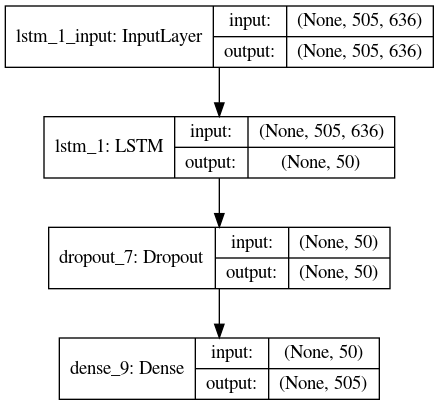

In [64]:
lstm_classif_v1 = Sequential([
                        LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
                        Dropout(0.1),
                        Dense(Y_train.shape[1], activation='sigmoid')                        
                        ])

print(lstm_classif_v1.summary())

plot_model(lstm_classif_v1, to_file=os.path.join(batch, 'lstm_classif1.png'), show_shapes=True)
Image.open(os.path.join(batch, 'lstm_classif1.png'))

In [65]:
lstm_classif_v1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
history = lstm_classif_v1.fit(X_train, Y_train, epochs=10, batch_size=1, validation_split=0.05, verbose=2, shuffle=False)

Train on 46 samples, validate on 3 samples
Epoch 1/10
 - 9s - loss: 0.6929 - accuracy: 0.5152 - val_loss: 0.6915 - val_accuracy: 0.5162
Epoch 2/10
 - 8s - loss: 0.6845 - accuracy: 0.5456 - val_loss: 0.6916 - val_accuracy: 0.5149
Epoch 3/10
 - 7s - loss: 0.6773 - accuracy: 0.5634 - val_loss: 0.6923 - val_accuracy: 0.5135
Epoch 4/10
 - 8s - loss: 0.6694 - accuracy: 0.5772 - val_loss: 0.6934 - val_accuracy: 0.4990
Epoch 5/10
 - 8s - loss: 0.6617 - accuracy: 0.5887 - val_loss: 0.6954 - val_accuracy: 0.5043
Epoch 6/10
 - 7s - loss: 0.6570 - accuracy: 0.5933 - val_loss: 0.6966 - val_accuracy: 0.4944
Epoch 7/10
 - 8s - loss: 0.6533 - accuracy: 0.5963 - val_loss: 0.6984 - val_accuracy: 0.4957
Epoch 8/10
 - 8s - loss: 0.6512 - accuracy: 0.5992 - val_loss: 0.7000 - val_accuracy: 0.4917
Epoch 9/10
 - 8s - loss: 0.6499 - accuracy: 0.5990 - val_loss: 0.7017 - val_accuracy: 0.4950
Epoch 10/10
 - 8s - loss: 0.6483 - accuracy: 0.6026 - val_loss: 0.7032 - val_accuracy: 0.4931


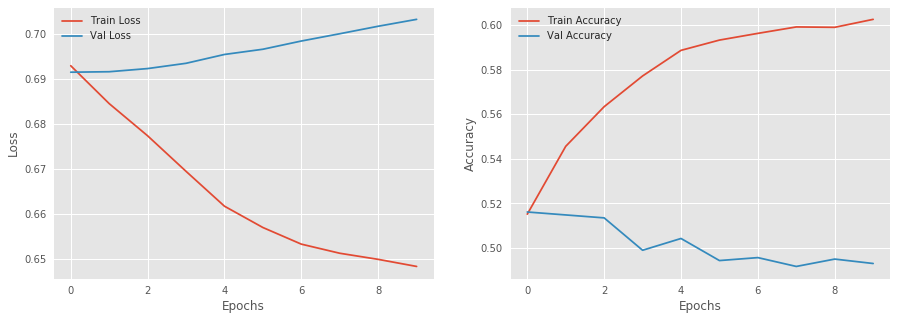

In [67]:
plot_loss_and_accuracy(history)

In [68]:
predictions = lstm_classif_v1.predict(X_test)
predictions_labels = np.where(predictions > 0.5, 1, 0)

print('Accuracy : %.3f'%accuracy_score(Y_test.flatten(), predictions_labels.flatten()))

Accuracy : 0.508


Classification Report : 
               precision    recall  f1-score   support

           0       0.46      0.65      0.54       451
           1       0.58      0.40      0.47       559

    accuracy                           0.51      1010
   macro avg       0.52      0.52      0.51      1010
weighted avg       0.53      0.51      0.50      1010

Confusion Matrix : 
 [[292 159]
 [338 221]]


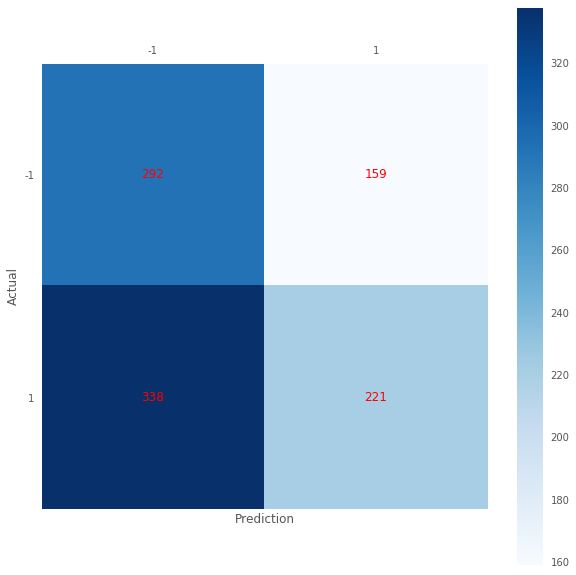

In [69]:
print_plot_metrics('LSTMV1', Y_test.flatten(), predictions_labels.flatten())

In [70]:
print_weights_per_layer(lstm_classif_v1)

Layer : LSTM : Weights : (636, 200)
Layer : Dense : Weights : (50, 200)
Layer : Dense : Bias : (200,)


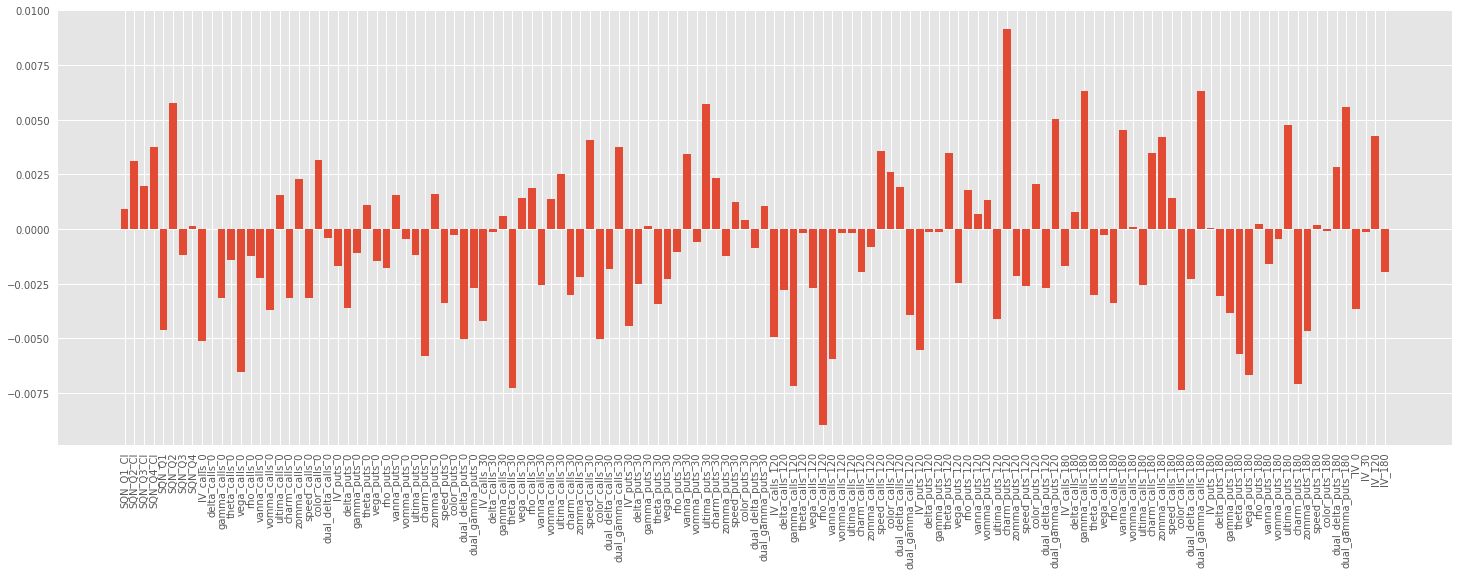

In [71]:
lstm_weights = lstm_classif_v1.get_weights()
important_weights = lstm_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights[:-505], width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_lstm_v1.png"), dpi=200)

In [72]:
lstm_classif_v1.save(os.path.join(batch,"lstm_classifier_v1.h5"))

In [73]:
lstm_classif_v1 = load_model(os.path.join(batch,"lstm_classifier_v1.h5"))

lstm_classif_v1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                137400    
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 505)               25755     
Total params: 163,155
Trainable params: 163,155
Non-trainable params: 0
_________________________________________________________________


In [74]:
def future_predictions(file_name, model):
    df = pd.read_csv(file_name)
    df = pd.get_dummies(df.drop(columns=["returns"]), columns=["ticker"])
    df = df.fillna(value=0)

    data = df.values
    data = data.reshape((1, data.shape[0], data.shape[1]))

    prediction_probs = model.predict(data).flatten()
    prediction_labels = np.where(prediction_probs > 0.5, 1, -1)
    
    return prediction_probs, prediction_labels

In [75]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

probs, labels = future_predictions(last_file, lstm_classif_v1)

probs[:5], labels[:5]

(array([0.54873776, 0.4921396 , 0.48464826, 0.59951407, 0.5450398 ],
       dtype=float32), array([ 1, -1, -1,  1,  1]))

In [76]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, lstm_classif_v1)
    tot_probs.extend(probs)
    tot_labels.extend(labels)
    
combined_df_final["LSTM_V1_Probs"] = tot_probs
combined_df_final["LSTM_V1_Preds"] = tot_labels

## 5. LSTM V2

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 505, 100)          294800    
_________________________________________________________________
lstm_3 (LSTM)                (None, 505, 50)           30200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_10 (Dense)             (None, 505)               15655     
Total params: 350,375
Trainable params: 350,375
Non-trainable params: 0
_________________________________________________________________
None


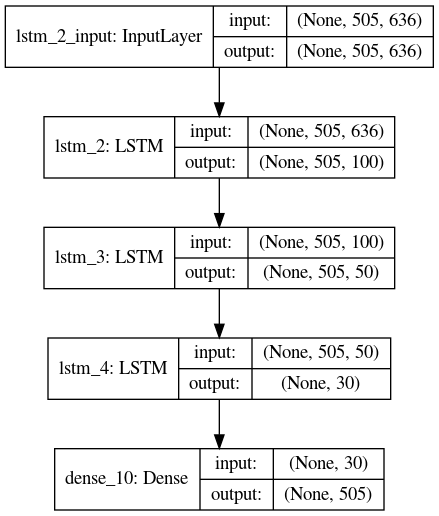

In [77]:
lstm_classif_v2 = Sequential([
                LSTM(units=100, return_sequences= True, input_shape=(X_train.shape[1],X_train.shape[2])),
                LSTM(units=50, return_sequences=True),
                LSTM(units=30),
                Dense(Y_train.shape[1], activation='sigmoid')
                ])

print(lstm_classif_v2.summary())

plot_model(lstm_classif_v2, to_file=os.path.join(batch, 'lstm_classif2.png'), show_shapes=True)
Image.open(os.path.join(batch, 'lstm_classif2.png'))

In [78]:
lstm_classif_v2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [79]:
history = lstm_classif_v2.fit(X_train, Y_train, epochs=10, batch_size=1, validation_split=0.05, verbose=2, shuffle=False)

Train on 46 samples, validate on 3 samples
Epoch 1/10
 - 27s - loss: 0.6907 - accuracy: 0.5173 - val_loss: 0.6911 - val_accuracy: 0.5149
Epoch 2/10
 - 26s - loss: 0.6772 - accuracy: 0.5538 - val_loss: 0.6969 - val_accuracy: 0.5030
Epoch 3/10
 - 26s - loss: 0.6675 - accuracy: 0.5704 - val_loss: 0.7035 - val_accuracy: 0.5010
Epoch 4/10
 - 26s - loss: 0.6643 - accuracy: 0.5750 - val_loss: 0.7059 - val_accuracy: 0.5063
Epoch 5/10
 - 26s - loss: 0.6632 - accuracy: 0.5756 - val_loss: 0.7063 - val_accuracy: 0.5017
Epoch 6/10
 - 26s - loss: 0.6625 - accuracy: 0.5741 - val_loss: 0.7048 - val_accuracy: 0.5056
Epoch 7/10
 - 27s - loss: 0.6619 - accuracy: 0.5757 - val_loss: 0.7009 - val_accuracy: 0.5023
Epoch 8/10
 - 26s - loss: 0.6612 - accuracy: 0.5793 - val_loss: 0.7017 - val_accuracy: 0.5089
Epoch 9/10
 - 26s - loss: 0.6597 - accuracy: 0.5802 - val_loss: 0.7023 - val_accuracy: 0.5089
Epoch 10/10
 - 26s - loss: 0.6566 - accuracy: 0.5852 - val_loss: 0.7077 - val_accuracy: 0.5116


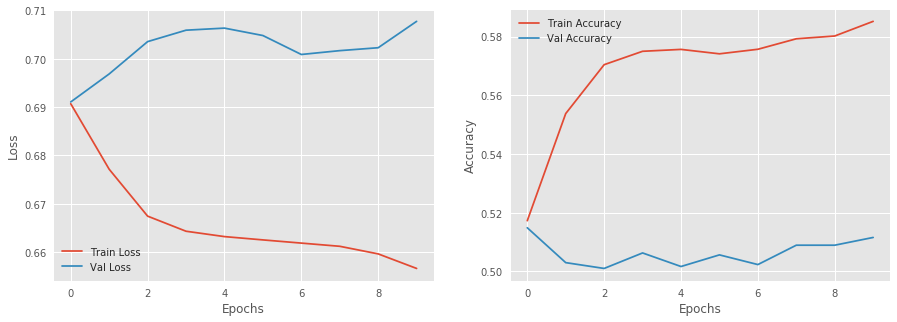

In [80]:
plot_loss_and_accuracy(history)

In [81]:
predictions = lstm_classif_v2.predict(X_test)
predictions_labels = np.where(predictions > 0.5, 1, 0)

print('Accuracy : %.3f'%accuracy_score(Y_test.flatten(), predictions_labels.flatten()))

Accuracy : 0.521


Classification Report : 
               precision    recall  f1-score   support

           0       0.47      0.65      0.55       451
           1       0.60      0.42      0.49       559

    accuracy                           0.52      1010
   macro avg       0.53      0.53      0.52      1010
weighted avg       0.54      0.52      0.52      1010

Confusion Matrix : 
 [[294 157]
 [327 232]]


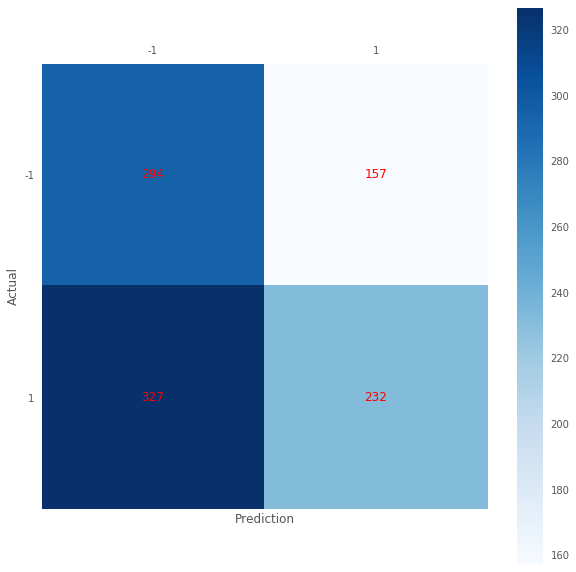

In [82]:
print_plot_metrics('LSTMV2', Y_test.flatten(), predictions_labels.flatten())

In [83]:
print_weights_per_layer(lstm_classif_v2)

Layer : LSTM : Weights : (636, 400)
Layer : LSTM : Weights : (100, 400)
Layer : LSTM : Weights : (400,)
Layer : Dense : Weights : (100, 200)
Layer : Dense : Bias : (50, 200)


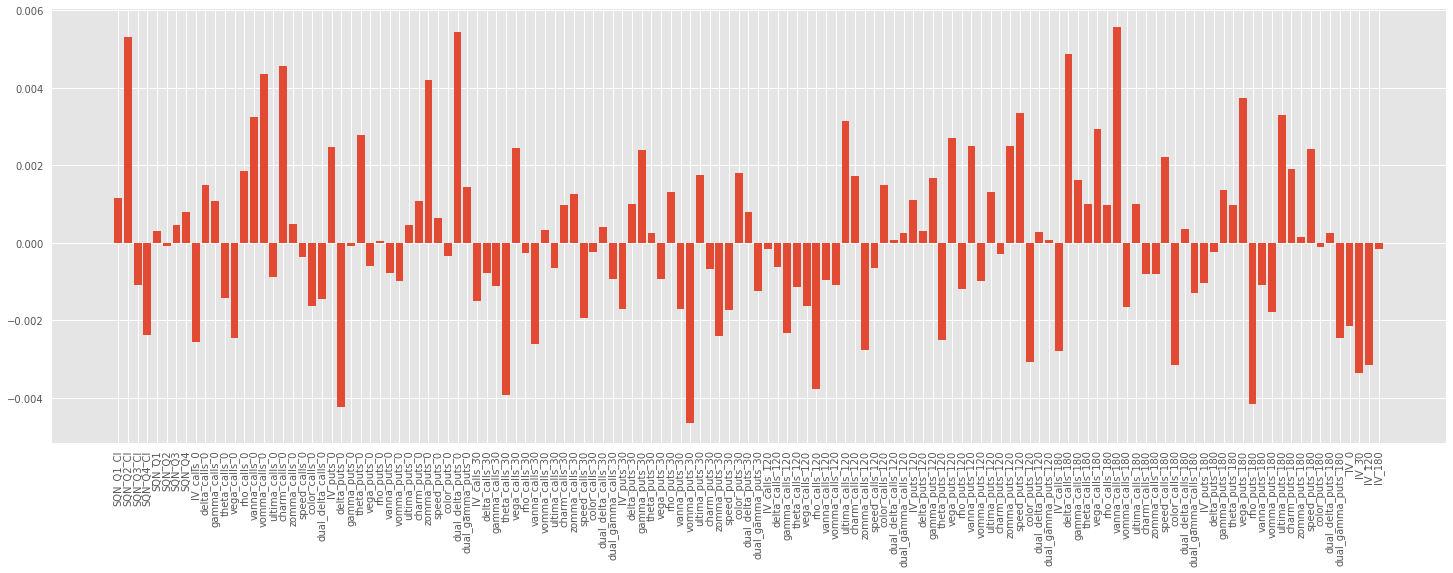

In [84]:
lstm_weights = lstm_classif_v2.get_weights()
important_weights = lstm_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights[:-505], width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_lstm_v2.png"), dpi=200)

In [85]:
lstm_classif_v2.save(os.path.join(batch,"lstm_classifier_v2.h5"))

In [86]:
lstm_classif_v2 = load_model(os.path.join(batch,"lstm_classifier_v2.h5"))

lstm_classif_v2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 505, 100)          294800    
_________________________________________________________________
lstm_3 (LSTM)                (None, 505, 50)           30200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_10 (Dense)             (None, 505)               15655     
Total params: 350,375
Trainable params: 350,375
Non-trainable params: 0
_________________________________________________________________


In [87]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

probs, labels = future_predictions(last_file, lstm_classif_v2)

probs[:5], labels[:5]

(array([0.6213011 , 0.56808126, 0.4859669 , 0.5883075 , 0.42792836],
       dtype=float32), array([ 1,  1, -1,  1, -1]))

In [88]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, lstm_classif_v2)
    tot_probs.extend(probs)
    tot_labels.extend(labels)
    
combined_df_final["LSTM_V2_Probs"] = tot_probs
combined_df_final["LSTM_V2_Preds"] = tot_labels

## 6. CNN LSTM

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 505, 32)     20384     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 252, 32)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 8064)        0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               3266000   
_________________________________________________________________
dense_11 (Dense)             (None, 505)               51005     
Total params: 3,337,389
Trainable params: 3,337,389
Non-trainable params: 0
_________________________________________________________________
None


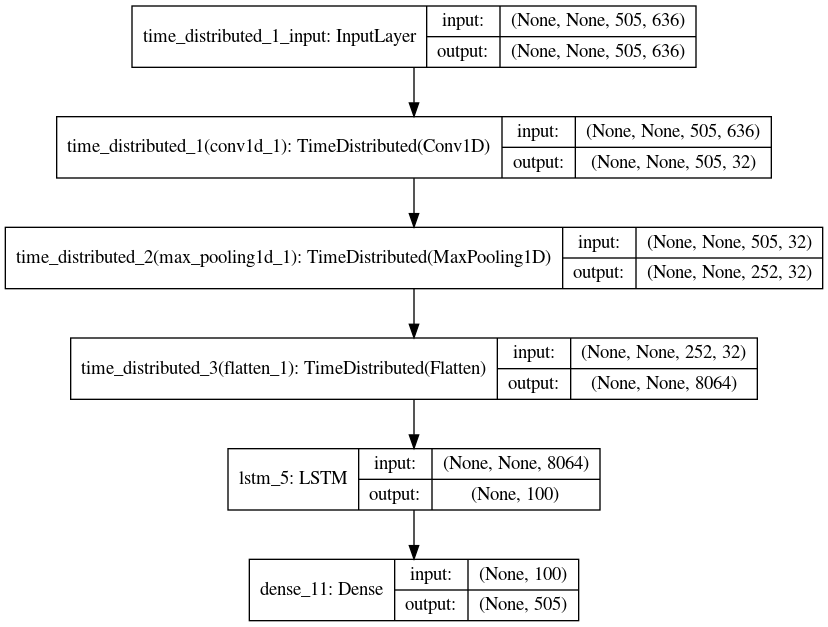

In [89]:
lstm_classif_v3 = Sequential([
    TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu'), input_shape=(None, X_train.shape[1], X_train.shape[2])),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    LSTM(100, activation='relu'),
    Dense(Y_train.shape[1], activation='sigmoid')
])


print(lstm_classif_v3.summary())

plot_model(lstm_classif_v3, to_file=os.path.join(batch, 'lstm_classif3.png'), show_shapes=True)
Image.open(os.path.join(batch, 'lstm_classif3.png'))

In [90]:
lstm_classif_v3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [91]:
history = lstm_classif_v3.fit(X_train.reshape(X_train.shape[0],1,X_train.shape[1], X_train.shape[2]), Y_train, epochs=10, batch_size=1, validation_split=0.05, verbose=2, shuffle=False)

Train on 46 samples, validate on 3 samples
Epoch 1/10
 - 5s - loss: 2.9643 - accuracy: 0.5101 - val_loss: 1.0130 - val_accuracy: 0.5248
Epoch 2/10
 - 4s - loss: 1.0393 - accuracy: 0.5336 - val_loss: 0.6927 - val_accuracy: 0.4937
Epoch 3/10
 - 4s - loss: 0.6954 - accuracy: 0.5696 - val_loss: 0.6924 - val_accuracy: 0.4977
Epoch 4/10
 - 4s - loss: 0.7130 - accuracy: 0.5749 - val_loss: 0.6922 - val_accuracy: 0.4990
Epoch 5/10
 - 4s - loss: 0.7375 - accuracy: 0.5786 - val_loss: 0.6920 - val_accuracy: 0.4990
Epoch 6/10
 - 3s - loss: 0.6868 - accuracy: 0.5825 - val_loss: 0.6918 - val_accuracy: 0.4970
Epoch 7/10
 - 3s - loss: 0.7043 - accuracy: 0.5826 - val_loss: 0.6916 - val_accuracy: 0.5010
Epoch 8/10
 - 3s - loss: 0.6848 - accuracy: 0.5835 - val_loss: 0.6915 - val_accuracy: 0.5010
Epoch 9/10
 - 3s - loss: 0.6828 - accuracy: 0.5847 - val_loss: 0.6914 - val_accuracy: 0.5003
Epoch 10/10
 - 3s - loss: 0.6855 - accuracy: 0.5848 - val_loss: 0.6913 - val_accuracy: 0.5003


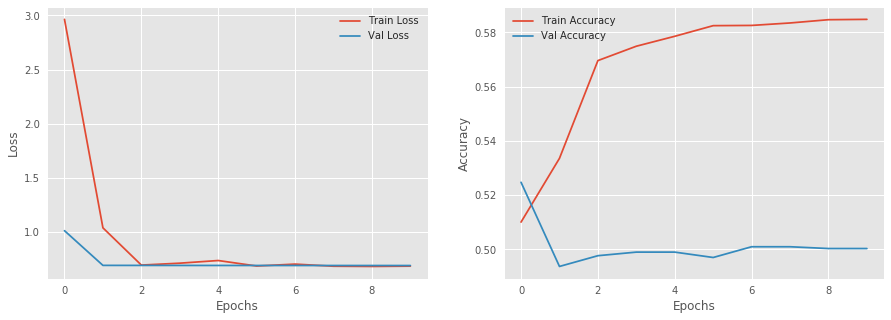

In [92]:
plot_loss_and_accuracy(history)

In [93]:
predictions = lstm_classif_v3.predict(X_test.reshape(X_test.shape[0],1,X_test.shape[1], X_test.shape[2]))
predictions_labels = np.where(predictions > 0.5, 1, 0)

print('Accuracy : %.3f'%accuracy_score(Y_test.flatten(), predictions_labels.flatten()))

Accuracy : 0.498


Classification Report : 
               precision    recall  f1-score   support

           0       0.46      0.64      0.53       451
           1       0.57      0.38      0.46       559

    accuracy                           0.50      1010
   macro avg       0.51      0.51      0.50      1010
weighted avg       0.52      0.50      0.49      1010

Confusion Matrix : 
 [[290 161]
 [346 213]]


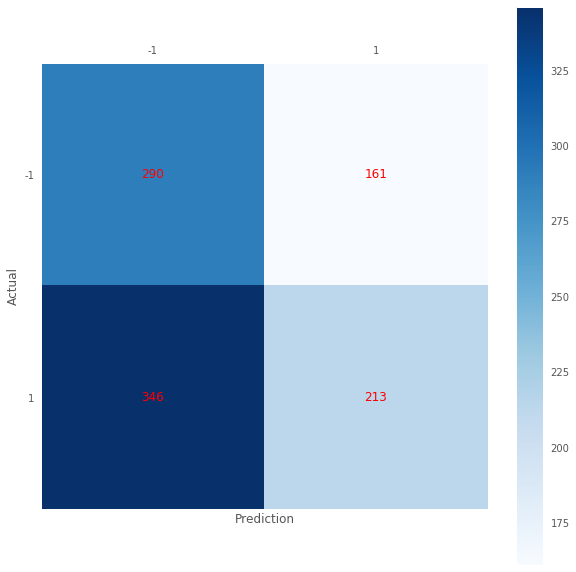

In [94]:
print_plot_metrics('LSTMV3', Y_test.flatten(), predictions_labels.flatten())

In [95]:
print_weights_per_layer(lstm_classif_v3)

Layer : TimeDistributed : Weights : (1, 636, 32)
Layer : TimeDistributed : Weights : (32,)
Layer : TimeDistributed : Weights : (8064, 400)
Layer : LSTM : Weights : (100, 400)
Layer : Dense : Weights : (400,)
Layer : Dense : Bias : (100, 505)


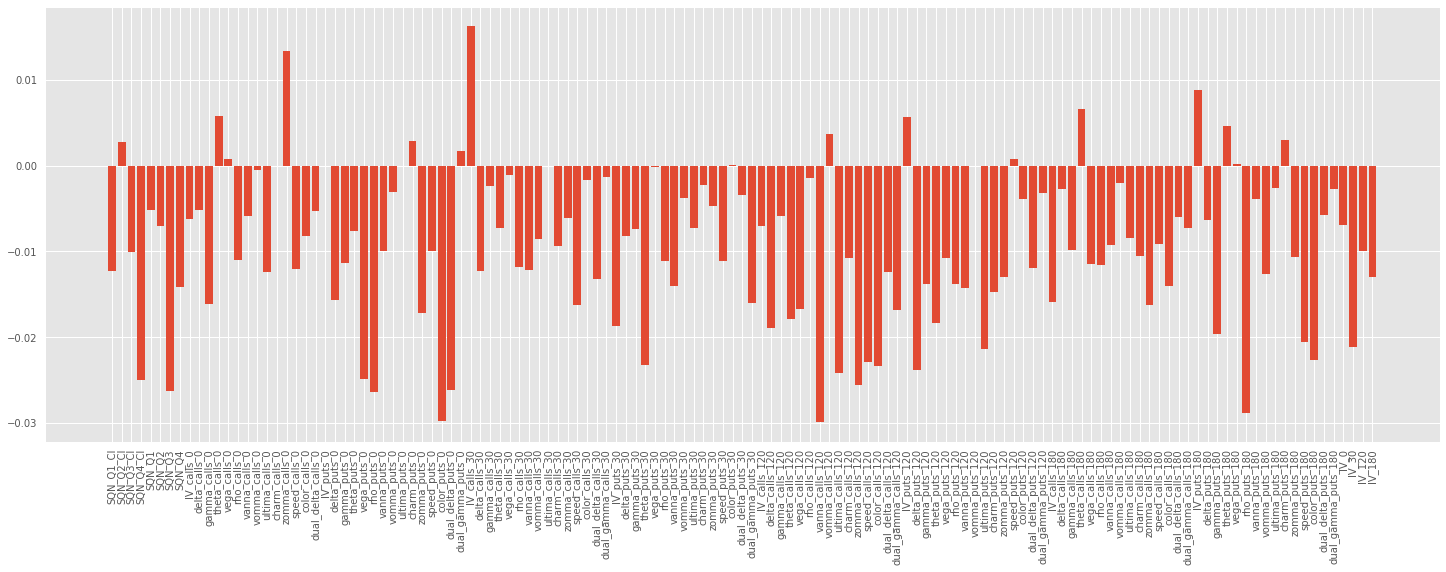

In [96]:
lstm_weights = lstm_classif_v3.get_weights()
important_weights = lstm_weights[0].mean(axis=2).flatten()

with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights[:-505], width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_lstm_v3.png"), dpi=200)

In [97]:
lstm_classif_v3.save(os.path.join(batch,"lstm_classifier_v3.h5"))

In [98]:
lstm_classif_v3 = load_model(os.path.join(batch,"lstm_classifier_v3.h5"))

lstm_classif_v3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 505, 32)     20384     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 252, 32)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 8064)        0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               3266000   
_________________________________________________________________
dense_11 (Dense)             (None, 505)               51005     
Total params: 3,337,389
Trainable params: 3,337,389
Non-trainable params: 0
_________________________________________________________________


In [99]:
def future_predictions(file_name, model):
    df = pd.read_csv(file_name)
    df = pd.get_dummies(df.drop(columns=["returns"]), columns=["ticker"])
    df = df.fillna(value=0)

    data = df.values
    data = data.reshape((1, 1, data.shape[0], data.shape[1]))

    prediction_probs = model.predict(data).flatten()
    prediction_labels = np.where(prediction_probs > 0.5, 1, -1)
    
    return prediction_probs, prediction_labels

In [100]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

probs, labels = future_predictions(last_file, lstm_classif_v3)

probs[:5], labels[:5]

(array([0.5163951 , 0.49847507, 0.5054005 , 0.52710354, 0.49167165],
       dtype=float32), array([ 1, -1,  1,  1, -1]))

In [101]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, lstm_classif_v3)
    tot_probs.extend(probs)
    tot_labels.extend(labels)
    
combined_df_final["LSTM_V3_Probs"] = tot_probs
combined_df_final["LSTM_V3_Preds"] = tot_labels

## 7. ConvLSTM

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 504, 64)        358656    
_________________________________________________________________
flatten_2 (Flatten)          (None, 32256)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 505)               16289785  
Total params: 16,648,441
Trainable params: 16,648,441
Non-trainable params: 0
_________________________________________________________________
None


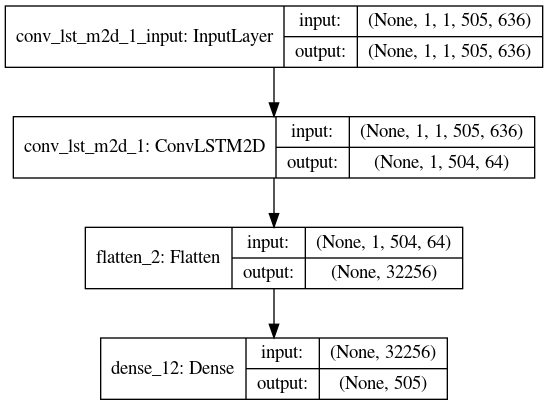

In [102]:
lstm_classif_v4 = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(1, 1, X_train.shape[1], X_train.shape[2])),
    Flatten(),
    Dense(Y_train.shape[1], activation='sigmoid')
])


print(lstm_classif_v4.summary())

plot_model(lstm_classif_v4, to_file=os.path.join(batch, 'lstm_classif4.png'), show_shapes=True)
Image.open(os.path.join(batch, 'lstm_classif4.png'))

In [103]:
lstm_classif_v4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [104]:
history = lstm_classif_v4.fit(X_train.reshape(X_train.shape[0],1, 1, X_train.shape[1], X_train.shape[2]), Y_train, epochs=10, batch_size=1, validation_split=0.05, verbose=2, shuffle=False)

Train on 46 samples, validate on 3 samples
Epoch 1/10
 - 54s - loss: 3.1293 - accuracy: 0.5270 - val_loss: 0.6928 - val_accuracy: 0.4964
Epoch 2/10
 - 15s - loss: 0.6632 - accuracy: 0.5946 - val_loss: 0.6927 - val_accuracy: 0.5050
Epoch 3/10
 - 13s - loss: 0.6232 - accuracy: 0.6158 - val_loss: 0.6921 - val_accuracy: 0.4997
Epoch 4/10
 - 14s - loss: 0.5633 - accuracy: 0.6819 - val_loss: 0.6887 - val_accuracy: 0.5228
Epoch 5/10
 - 13s - loss: 0.5310 - accuracy: 0.6877 - val_loss: 0.6905 - val_accuracy: 0.5122
Epoch 6/10
 - 12s - loss: 0.5100 - accuracy: 0.7087 - val_loss: 0.6903 - val_accuracy: 0.5234
Epoch 7/10
 - 12s - loss: 0.4773 - accuracy: 0.7332 - val_loss: 0.6916 - val_accuracy: 0.5010
Epoch 8/10
 - 12s - loss: 0.4587 - accuracy: 0.7504 - val_loss: 0.6912 - val_accuracy: 0.5142
Epoch 9/10
 - 12s - loss: 0.4377 - accuracy: 0.7619 - val_loss: 0.6944 - val_accuracy: 0.5274
Epoch 10/10
 - 12s - loss: 0.4214 - accuracy: 0.7780 - val_loss: 0.6973 - val_accuracy: 0.5267


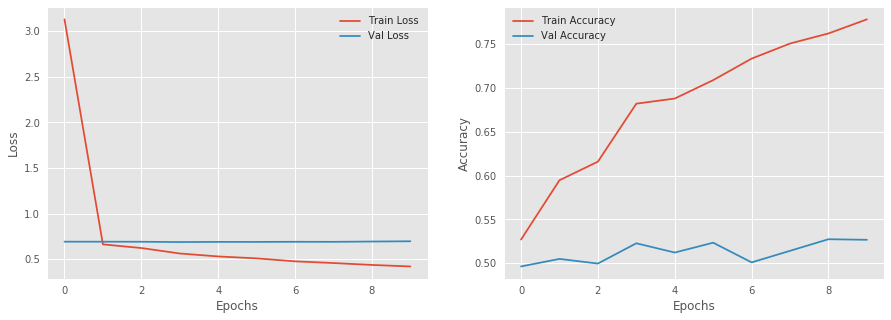

In [105]:
plot_loss_and_accuracy(history)

In [106]:
predictions = lstm_classif_v4.predict(X_test.reshape(X_test.shape[0],1,1,X_test.shape[1], X_test.shape[2]))
predictions_labels = np.where(predictions > 0.5, 1, 0)

print('Accuracy : %.3f'%accuracy_score(Y_test.flatten(), predictions_labels.flatten()))

Accuracy : 0.495


Classification Report : 
               precision    recall  f1-score   support

           0       0.45      0.58      0.51       451
           1       0.56      0.43      0.48       559

    accuracy                           0.50      1010
   macro avg       0.50      0.50      0.49      1010
weighted avg       0.51      0.50      0.49      1010

Confusion Matrix : 
 [[261 190]
 [320 239]]


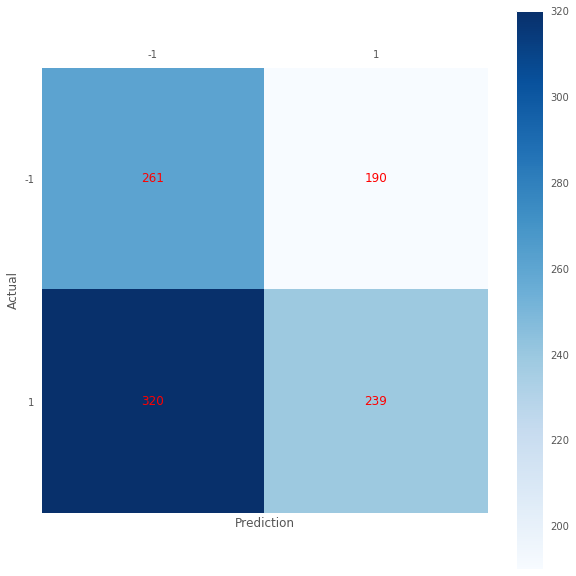

In [107]:
print_plot_metrics('LSTMV4', Y_test.flatten(), predictions_labels.flatten())

In [108]:
print_weights_per_layer(lstm_classif_v4)

Layer : ConvLSTM2D : Weights : (1, 2, 636, 256)
Layer : Flatten : Weights : (1, 2, 64, 256)
Layer : Dense : Weights : (256,)
Layer : Dense : Bias : (32256, 505)


(1, 2, 636, 256)


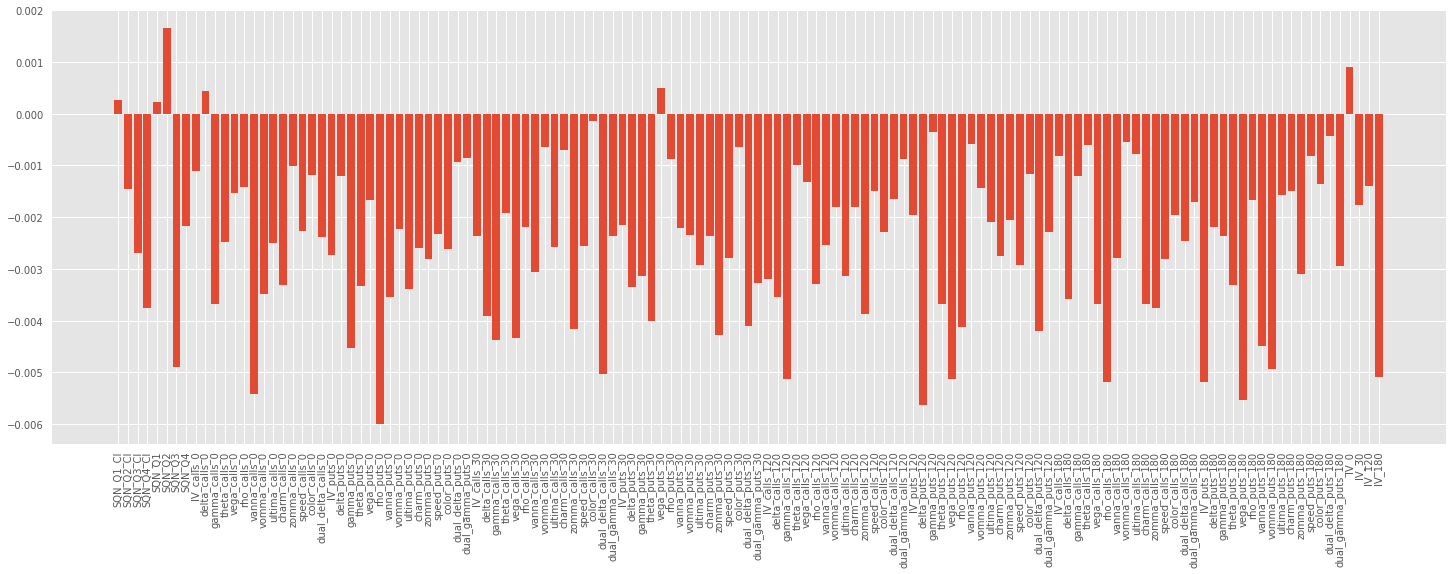

In [109]:
lstm_weights = lstm_classif_v4.get_weights()
print(lstm_weights[0].shape)
important_weights = lstm_weights[0].mean(axis=3).mean(axis=1).flatten()

with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights[:-505], width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_lstm_v4.png"), dpi=200)

In [110]:
lstm_classif_v4.save(os.path.join(batch,"lstm_classifier_v4.h5"))

In [111]:
lstm_classif_v4 = load_model(os.path.join(batch,"lstm_classifier_v4.h5"))

lstm_classif_v4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 504, 64)        358656    
_________________________________________________________________
flatten_2 (Flatten)          (None, 32256)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 505)               16289785  
Total params: 16,648,441
Trainable params: 16,648,441
Non-trainable params: 0
_________________________________________________________________


In [112]:
def future_predictions(file_name, model):
    df = pd.read_csv(file_name)
    df = pd.get_dummies(df.drop(columns=["returns"]), columns=["ticker"])
    df = df.fillna(value=0)

    data = df.values
    data = data.reshape((1, 1, 1, data.shape[0], data.shape[1]))

    prediction_probs = model.predict(data).flatten()
    prediction_labels = np.where(prediction_probs > 0.5, 1, -1)
    
    return prediction_probs, prediction_labels

In [113]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

probs, labels = future_predictions(last_file, lstm_classif_v4)

probs[:5], labels[:5]

(array([0.78674585, 0.60095906, 0.46855494, 0.5713408 , 0.5261967 ],
       dtype=float32), array([ 1,  1, -1,  1,  1]))

In [114]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, lstm_classif_v4)
    tot_probs.extend(probs)
    tot_labels.extend(labels)
    
combined_df_final["LSTM_V4_Probs"] = tot_probs
combined_df_final["LSTM_V4_Preds"] = tot_labels

## Writing Final CSV With Probs & Predicted Labels to Disk

In [115]:
combined_df_final.tail()

ticker  SQN_Q1_CI  SQN_Q2_CI  SQN_Q3_CI  SQN_Q4_CI  SQN_Q1  SQN_Q2  \
500    YUM      291.0       62.0       57.0      487.0   244.0    78.0   
501    ZBH      289.0       95.0      432.0      257.0   295.0   102.0   
502   ZBRA      125.0      108.0      303.0        6.0   190.0   110.0   
503   ZION      273.0      351.0      451.0       22.0   268.0   349.0   
504    ZTS      188.0        7.0       25.0      433.0   148.0     8.0   

     SQN_Q3  SQN_Q4  IV_calls_0  ...  XGB_Probs  XGB_Preds  LSTM_V1_Probs  \
500    79.0   453.0       381.0  ...   0.470374         -1       0.535276   
501   442.0   251.0       303.0  ...   0.480517         -1       0.448804   
502   253.0    28.0        84.0  ...   0.565301          1       0.455864   
503   457.0    15.0       246.0  ...   0.534203          1       0.444360   
504    78.0   403.0       344.0  ...   0.530172          1       0.488540   

     LSTM_V1_Preds  LSTM_V2_Probs  LSTM_V2_Preds  LSTM_V3_Probs  \
500              1       0.470376             -1       0.507518   
501             -1       0.425301             -1       0.481351   
502             -1       0.536791              1       0.495265   
503             -1       0.448278             -1       0.490022   
504             -1       0.446106             -1       0.474537   

     LSTM_V3_Preds  LSTM_V4_Probs  LSTM_V4_Preds  
500              1       0.500539              1  
501             -1       0.481514             -1  
502             -1       0.676706              1  
503             -1       0.251991             -1  
504             -1       0.544808              1  

[5 rows x 147 columns]

In [116]:
combined_df_final.to_csv(os.path.join(batch,"final.csv"))

In [117]:
combined_df_final[-(505 *2):].to_csv(os.path.join(batch,"test_probs.csv"))